<h1>Abstract</h1>
Hello, we are Gilad Battat and Doron Gaznavi and we are Computer Science students at The Open University Of Israel.
<br> 
In this project we've decided to focus on diagnosing tumors in brain MRI scans.<br>
After searching and experimenting with datasets in this field, we decided to take this dataset from Kaggle <a href="https://www.kaggle.com/sartajbhuvaji/brain-tumor-classification-mri">here</a>. We found it as the best choice to our purposes. This dataset contains more than 3K images as jpg files. <br>
<h6>Short general information about brain tumors</h6>
<ul>
    <li>Survival rate within 5 years for people who are diagnosed with a cancerous brain tumor is about 34% for men and 36% for women.</li>
    <li>50% of the brain tumors occurrences are primary tumors, that is to say, they start their growth in the brain. The rest are a result of a tumor that has spread to the brain from other location in the body</li>
</ul>
<h6>Data description</h6>
In this dataset we have four types of MRI scans:
    <ol>
        <li><b>No tumor:</b> Contains images without any tumor.</li>
    <li><b>Glioma tumor:</b> This is a cancer tumor that takes over 30% over all of the tumors occurrences in the brain and in the nervous system, and over 80% of the occurrences of malignant brain cancer.</li>
    <li><b>Meningioma tumor:</b> This type is a benign tumor, it appears in the layers surrounding the brain and typically has slow growth rate. Although this is a benign tumor, without close tracking and treatment the pressure it makes on the brain tissues might cause nervous disorders.</li>
    <li><b>Pituitary tumor:</b> This is a cancer tumor in the Pituitary Gland. This tumor might cause changes in the hormone levels in the body that in turn might cause many bad medical conditions.</li>
    </ol>
Currently, the way to observe brain tumor is to analyze MRI scans with professional neurosurgeon. This method requires expensive time of professional neurosurgeons which are not always available all over the world. Furthermore, in other medical fields, ML applications have shown to be more accurate than human specialists. Thus, using machine learning techniques to analyze brain MRI scans to find tumors, we wish to get better and faster results. 
<br>

# EDA

We start with importing all the relevant modules for the project.<br>
Next we are setting the current directory to the place where we stored the dataset.

In [ ]:
import tensorflow as tf
import os
import cv2
from tqdm.notebook import tqdm_notebook as tqdm
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense, MaxPooling2D
from keras.layers import Flatten, BatchNormalization
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import warnings
warnings.filterwarnings('ignore')


In [ ]:
root_dir = '\\Users\\doron\\Data science\\Project'
os.chdir(root_dir)

Now we will examine the general features of Meningioma image: size, format and color mode. <br>

In [ ]:
from PIL import Image

os.chdir('Training/meningioma_tumor')
meningioma_tumors = os.listdir()
image = Image.open(meningioma_tumors[8])
# summarize some details about the image
print(f"Image format: {image.format}")
print(f"Color mode: {image.mode}")
print(f"Image size: {image.size}")
# return to the root directory
os.chdir(root_dir)

Image format: JPEG
Color mode: RGB
Image size: (512, 512)


So we know now that all our images are colored JPEG images in RGB format and they don't have the same size. <br>
We need them to be in the same size so we could perform them all in the same model later on

In [ ]:
image_format = True
image_mode = True
image_size = (512,512)

train_paths = ['Training/no_tumor',
               'Training/glioma_tumor',
               'Training/meningioma_tumor',
               'Training/pituitary_tumor']
test_paths = ['Testing/no_tumor',
              'Testing/glioma_tumor',
              'Testing/meningioma_tumor',
              'Testing/pituitary_tumor']
images_paths = train_paths + test_paths
for path in images_paths:
    os.chdir(path)
    for image in os.listdir():
        image = Image.open(image)
        if image.format != "JPEG":
            image_format = False
        if image.mode != "RGB":
            image_format = False
        if image.size != (512, 512):
            image_size = False
    os.chdir(root_dir)
    
print(f"All the images has the same size: {image_size}")
print(f"All the images has the same image format: {image_format}")
print(f"All the images in the same color mode: {image_mode}")

All the images has the same size: False
All the images has the same image format: True
All the images in the same color mode: True


In [ ]:
images = []
for path in images_paths:
    os.chdir(path)
    for item in os.listdir():
        img = cv2.imread(item)
        images.append(img)
    os.chdir(root_dir)
diff_threshold = 100
bad_images = []
for ind, img in enumerate(images):
    if abs(img.shape[0] - img.shape[1]) > diff_threshold:
        bad_images.append(img) 

print(f"We have {len(images)} images in our dataset {len(bad_images)} of them have more than {diff_threshold} difference between their hight and width")        

We have 3264 images in our dataset 69 of them have more than 100 difference between their hight and width


Later, we must apply resizing to set all the images to an unified input format for the models that will be used for classifying. <br>
We decided to take 100 pixels as our threshold for the size difference between 
the axis of the images. <br>
It's a good place in the middle in which we prevent dropping out too many images, and yet keep the images readable and prevent from smearing them by resizing them.<br>
To get things in context, these are some of the "bad images" we detected:

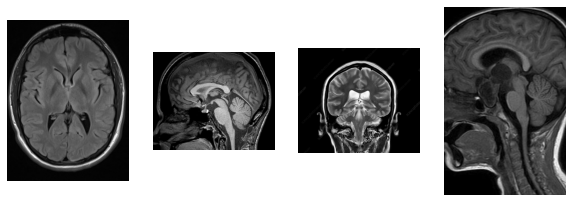

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(bad_images[i])
    plt.axis('off')
plt.show()

Lets see what happens to a non proportional image after resizing it.<br>
The original image is the size of 714X100 which means 286 pixels difference between it's length and width. 

In [ ]:
bad_images[6].shape

(714, 1000, 3)

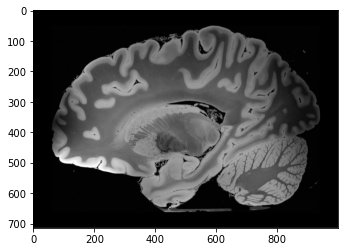

In [ ]:
plt.imshow(bad_images[6])   

And now we will check how this image will look like after resizing, will it stay simillar to the original image or will it look totally different? 

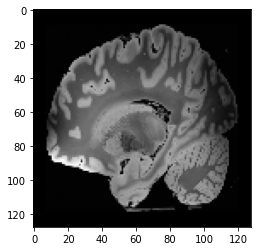

In [ ]:
img = cv2.resize(bad_images[6],(128,128))
plt.imshow(img)   

This is definitely different from the original image.<br> 
Therefore, as said we will prevent from training our models on such images in concern that they will  interrupt the learning process.<br>
To sum up, we have 3264 images in our dataset and we won't use 69 of them. 

<h3>Moving to gray scale</h3>

As we can see, although the images have 3 color channels, it is not necessary to keep all of them because in the end they create a gray scale image. <br>
Therefore we decided to convert all the images to gray scale.

In [ ]:
print(f"Image for example:{images[0].shape}")

Image for example:(350, 350, 3)


In [ ]:
for ind, img in enumerate(images):
    images[ind] = cv2.cvtColor(images[ind],cv2.COLOR_RGB2GRAY)

In [ ]:
print(f"The same Image from above has now the shape of {images[0].shape}")

The same Image from above has now the shape of (350, 350)


And all the images in the dataset still look the same:

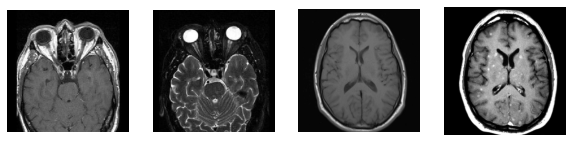

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.axis('off')
plt.show()

Now all the pixel values are stored with direct value in the image matrix and not as a tuple

In [ ]:
print(f"Pixel vlaue for example: {images[0][6][40]}")

Pixel vlaue for example: 3


## Pixel Value normalization

In general, inputs with large integer values might slow down the learning time of the neural networks and disrupt them. <br>
Hence it's considered a good practice to normalize the pixel values so that each pixel value has a value between 0 and 1.
In addition images can be viewed normally with pixel values in the range 0-1 so it won't hurt the visualization.

In [ ]:
print(f"Images data type:{type(images[0])}")
print(f"Pixels data type:{images[0].dtype}")

Images data type:<class 'numpy.ndarray'>
Pixels data type:uint8


In [ ]:
for ind, img in enumerate(images):
    img = np.array(img, dtype="float32")
    img /= 255.0
    images[ind] = img
    

In [ ]:
print(f"Images data type:{type(images[0])}")
print(f"Pixels data type:{images[0].dtype}")


Images data type:<class 'numpy.ndarray'>
Pixels data type:float32


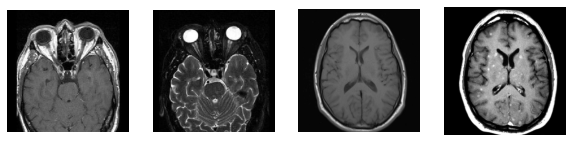

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(images[i], cmap="gray")
    plt.axis('off')
plt.show()

But now, the same pixel that had the value of three before, has totally different representation:

In [ ]:
print(f"The new value of the pixel is: {images[0][6][40]}")

The new value of the pixel is: 0.0117647061124444


In [ ]:
os.chdir(root_dir)

Now, after we saw how to prepare the data for the learning, we will load the images again but now with respect to classes in the train / test sets. 
We will use the function below to load each image and prepare it for learning by normalizing the pixels values, moving to gray scale and appending to the train and test sets - only images who have a good relation between it's length and width.
We've decided to reduce the resolution of the images in order to reduce the number of learned features to speed up the running time, and yet get good classification results.

In [ ]:
def load_data(path, classification, x, y, resolution=128, diff_threshold=100):
    os.chdir(path)
    print(path)
    for item in tqdm(os.listdir()):
        img = cv2.imread(item)
        if abs(img.shape[0] - img.shape[1]) > diff_threshold:
            continue
        img = cv2.resize(img,(resolution,resolution))
        img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        img = np.array(img, dtype="float32")
        img /= 255.0
        x.append(img)
        y.append(classification)
    os.chdir(root_dir)
    return x, y

As said our dataset is already organized into test and training sets so at first we will stick to this division. <br>
To avoid loading the data multiple times, we always save the original loaded data as is in the X_train, Y_train, X_test, Y_test variables.<br>
We won't use these variables directly and on each time we wish to start from clean data we will copy their content to x_train, y_train, x_test, y_test and manipulate only them.

In [ ]:
X_train, Y_train = [], []
resolution = 128
train_paths = ['Training/no_tumor',
               'Training/glioma_tumor',
               'Training/meningioma_tumor',
               'Training/pituitary_tumor']
               
for index, path in enumerate(train_paths):
    X_train, Y_train = load_data(path, index, X_train, Y_train, resolution)

Training/no_tumor



Training/glioma_tumor



Training/meningioma_tumor



Training/pituitary_tumor


Load testing data from the folders.

In [ ]:
X_test, Y_test = [], []
test_paths = ['Testing/no_tumor',
              'Testing/glioma_tumor',
              'Testing/meningioma_tumor',
              'Testing/pituitary_tumor']

for index, path in enumerate(test_paths):
    X_test, Y_test = load_data(path, index, X_test, Y_test, resolution)

Testing/no_tumor



Testing/glioma_tumor



Testing/meningioma_tumor



Testing/pituitary_tumor


Here we are copying the data before manipulating it. <br> 
We will see it many more times in the notebook.

In [ ]:
x_train, y_train = X_train.copy(), Y_train.copy()
x_test, y_test = X_test.copy(), Y_test.copy()

For example, here we can see the first four images in our training set. <br>
They all are clean from tumors.

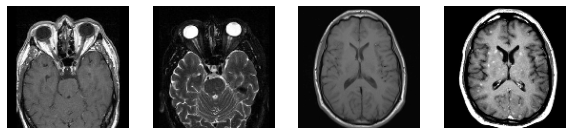

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(x_train[i], cmap="gray")
    plt.axis('off')
plt.show()

<h3>Classes and data</h3>

Now we will check the relations between the amount of data we have from each class in our dataset:

In [ ]:
import seaborn as sns
def plot_bar_graph(labels, y_samples, title):
    data = []
    for y_value in set(y_samples):
        data.append([y for y in y_samples if y == y_value])

    fig, ax = plt.subplots(figsize=(5, 5))
    sns.countplot(data=data)
    ax.set_xticklabels(labels)
    ax.set_title(title)
    plt.show()

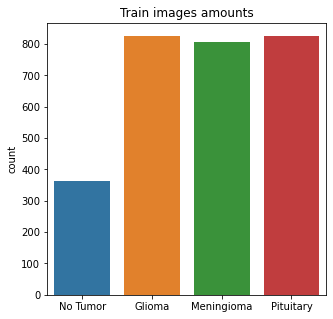

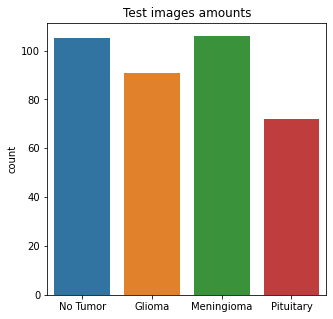

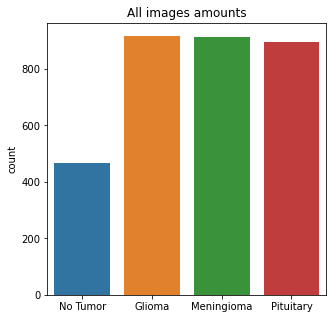

In [ ]:
labels = ["No Tumor", "Glioma", "Meningioma", "Pituitary"]
plot_bar_graph(labels, y_train, "Train images amounts")
plot_bar_graph(labels, y_test, "Test images amounts")
plot_bar_graph(labels, y_train + y_test, "All images amounts")

In [ ]:
def plot_classes_as_pie(y_value, title):
    labels = ["No tumor", "Glioma", "Meningioma", "Pituitary"]
    unique, counts = np.unique(np.array(y_value), return_counts=True)
    classes_amount_map = dict(zip(unique, counts))
    plt.pie(list(classes_amount_map.values()), labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
    plt.title(title)
    plt.axis('equal')
    plt.show()

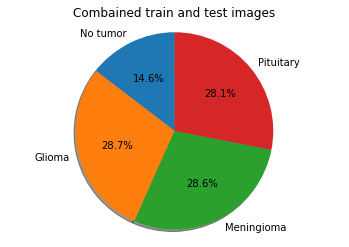

In [ ]:
plot_classes_as_pie(y_train+y_test, "Combained train and test images")

It seems that there is no balance between all the classes, especially in the No-Tumor class. 

# Classify with CNN - first attempt

Before giving our data to the model, we need to manipulate it so it will fit the input type that the model expects, and the output data type that the model generates in order to be able to calculate the loss function.
The last layer in our model is softmax, this layer has four neurons each of which represents one tumor category.
It's output tells us how likely it is that a given input is in the neuron's category.
In order to compare the model's output with the actual labels, we use to_categorical function that convert each classification value to single dimension np array with four calls. Each cell is corresponding  to one class. 
For example: label with value of '2' will convert to [0,0,1,0] and '1' to [0,1,0,0] and so on.

In [ ]:
def adjust_dataset_to_CNN(x_train, x_test, y_train, y_test):
    y_train = np.array(y_train, dtype="int64")
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=4)

    y_test = np.array(y_test, dtype="int64")
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=4)

    x_train = np.array(x_train)
    x_test = np.array(x_test)
    
    x_train = x_train.reshape(x_train.shape + (1,))
    x_test = x_test.reshape(x_test.shape + (1,))
    
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = adjust_dataset_to_CNN(x_train, x_test, y_train, y_test)

In [ ]:
model = Sequential(
        [
            Convolution2D(32, (3,3), activation ='relu', input_shape = (128, 128,1)),
            MaxPooling2D(pool_size=2),
            Convolution2D(filters=64, kernel_size=4, padding='same', activation='relu'),
            MaxPooling2D(pool_size=2),
            Convolution2D(filters=128, kernel_size=3, padding='same', activation='relu'),
            MaxPooling2D(pool_size=2),
            Convolution2D(filters=128, kernel_size=2, padding='same', activation='relu'),
            MaxPooling2D(pool_size=2),
            Dropout(0.25),
            Flatten(),
            Dense(units=128,activation = 'relu'),
            Dense(units = 64, activation = 'relu'),
            Dense(units = 32, activation = 'relu'),
            Dense(units = 4, activation = 'softmax')
        ]
    )

Here we choose Adam as the optimizer because it is known to surpass gradient descent in optimization. We also choose Categorical Cross Entropy as the loss function because this loss function is suitable for multi-class classification with CNN. Accuracy seems like a good general measurement, and we fit the model for 13 epochs.

In [ ]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [ ]:
history = model.fit(x_train,y_train,
                    epochs=13, 
                    validation_data=(x_test,y_test),
                    verbose = False,
                    shuffle=True, 
                   )

12/12 [==============================] - 1s 67ms/step - loss: 5.2958 - accuracy: 0.7139


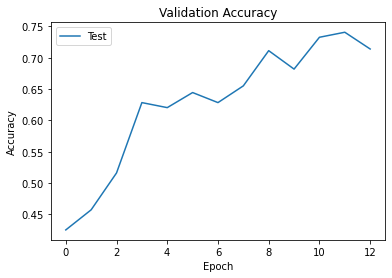

In [ ]:
model.evaluate(x_test,y_test)
plt.plot(history.history['val_accuracy'])
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Test'], loc='upper left')
plt.show()

The model learned pretty fast but it seems like he had a boundary of 0.7 that he didn't succeeded to overcome.

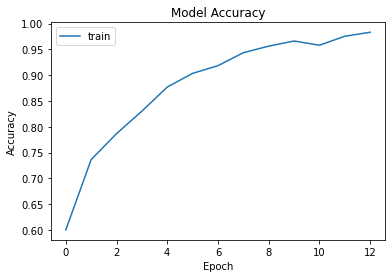

In [ ]:
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train'], loc='upper left')
plt.show()

The model learned the train images very vast and from epoch 8 it didn't had any significant improvement.

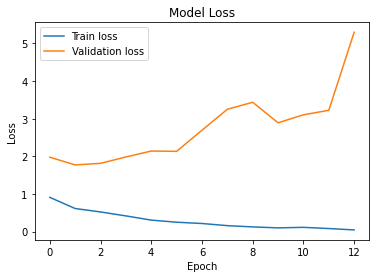

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Validation loss'], loc='upper left')
plt.show()

As expected from the previous graphs, we can see here that from epoch 10 the model started to over fit and memorize the training images.

<h5>Preparing the data to analysis</h5>

In [ ]:
y_predicted = model.predict_classes(x_test)
# Get back from catagorical to lables
y_actual = np.argmax(y_test,axis=1) 

<h6>Classification results examples</h6>

In [ ]:
def plot_classified_images(x_test, y_predicted, y_actual):
    tags_to_names = {0:"No Tumor", 1:"Glioma", 2:"Meningioma", 3:"Pituitary"}
    length = 2
    width = 2
    fig, axes = plt.subplots(length, width, figsize = (12,12))
    axes = axes.ravel()
    for i in np.arange(0, length * width): 
        sample_index = i*100
        axes[i].imshow(x_test[sample_index], cmap='gray')
        predicted = tags_to_names[y_predicted[sample_index]]
        actual = tags_to_names[y_actual[sample_index]]
        axes[i].set_title(f"Predicted Class = {predicted}\n Actual Label = {actual}")
        axes[i].axis('off')
    plt.subplots_adjust(wspace=0.5)

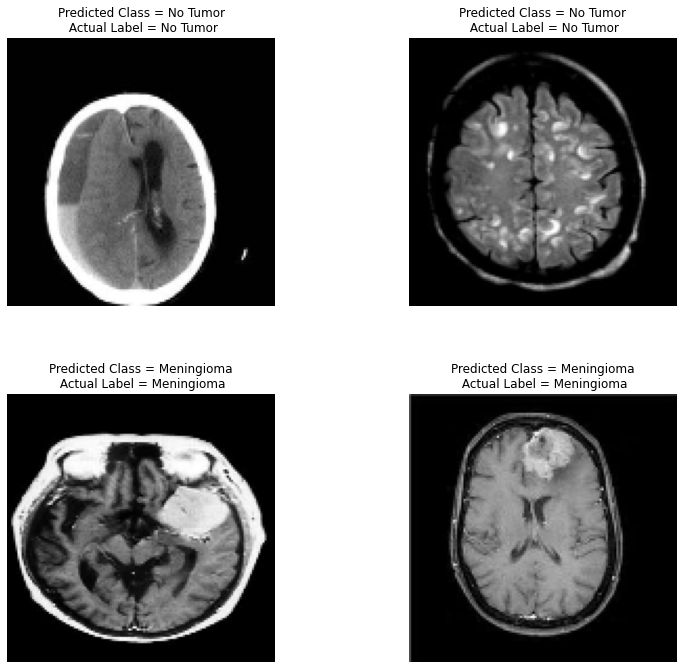

In [ ]:
plot_classified_images(x_test, y_predicted, y_actual)

<h3> Classification explanation </h3>
<ul>
  <li><b>Precision:</b> The ratio TP/(TP + FP) the lower the false positives the higher the precision.<br>
    <u>When there are no false positives the precision is 1.00.</u>
    <br></li>
  <li><b>Recall:</b> The ratio TP/(TP + FN) the lower the false negatives the higher the recall.<br>
    <u>When there are no false negatives the recall is 1.00.</u>
    <br></li>
  <li><b>f1-score:</b> The Harmonic average of precision and recall. f1-score = 2 * p * r / (p + r).</li>
  <li><b>Support:</b> Number of items in the class.</li>
  <li><b>Accuracy:</b> Total accuracy of the model.</li>
  <li><b>Macro avg:</b> Average precision, recall and F1 score between all the classes.</li>
    <li><b>weighted avg:</b> Weighted Average precision, recall and F1 score between all the classes with respect to relative number of items in each class.</li>
</ul>

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_actual, y_predicted))

              precision    recall  f1-score   support

           0       0.65      1.00      0.79       105
           1       1.00      0.19      0.31        91
           2       0.67      0.95      0.79       106
           3       0.96      0.61      0.75        72

    accuracy                           0.71       374
   macro avg       0.82      0.69      0.66       374
weighted avg       0.80      0.71      0.67       374



<h4>Confusion matrix</h4>
<p>Another way to examine our results is using confusion matrix which compare the labels that the model predicted with the actual labels that it was supposed to predict.</p>

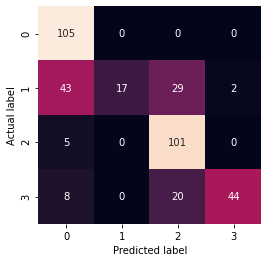

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
def plot_conf_mat(conf_mat):
    fig, ax = plt.subplots(figsize=(4,4))
    ax = sns.heatmap(conf_mat,
                    annot=True,
                    cbar=False,
                    fmt='d')
    plt.xlabel("Predicted label")
    plt.ylabel("Actual label")

conf_mat = confusion_matrix(y_actual, y_predicted)
plot_conf_mat(conf_mat)    


<h4>Report conclusion</h4>
<ol>
    <li>We have huge number of false negatives in class 1 - Glioma tumor, and it causes the other classes to produce false positives.<br> So maybe we need to train our network more on the Glioma tumor.</li>
    <li>In addition, the precision of classes 1 and 3 is high so in case of classification to one of these classes we can be pretty sure that the classification was correct.</li>
</ol>

# Other classification methods
As mentioned, CNN seems to be the best approach to solve our classification task but we didn't get the performances that we were wishing for.<br>
We thought to preform hyper parameters tuning but with our limited hardware we couldn't apply it on CNN, instead we decided to give it a chance on faster classification algorithms that has lower starting point in compare to CNN but run much faster.<br>
In this chapter we will detail this approach.



In [ ]:
# start from the begining - load again
x_train, y_train = X_train.copy(), Y_train.copy()
x_test, y_test = X_test.copy(), Y_test.copy()

Here we try to create two different models, one based on Naive Bayes and another based on Logistic Regression. 

First, we need to reshape the data so it will fit to the fit function of sklearn.

In [ ]:
x_train = np.array(x_train)
x_train.shape

(2821, 128, 128)

In [ ]:
def adjust_dataset_to_sklearn(x_train, x_test, y_train, y_test):
    x_train = np.array(x_train)
    nsamples, n1, n2 = x_train.shape
    x_train = x_train.reshape((nsamples,n1*n2))

    x_test = np.array(x_test)
    nsamples, n1, n2 = x_test.shape
    x_test = x_test.reshape((nsamples,n1*n2))

    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = adjust_dataset_to_sklearn(x_train, x_test, y_train, y_test)

Then we import the relevant modules:

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

And we define this function we could use it again later.
It takes a dictionary of classifier name and it's keras function training the classifier on our data.

In [ ]:
def different_models(Classifiers, x_train, x_test, y_train, y_test):
    for classifier in Classifiers.keys():
        clf = Classifiers[classifier]
        clf.fit(x_train, y_train)
        predict = clf.predict(x_test)
        print(f'{classifier} classification report: \n')
        print(classification_report(y_test, predict))

We are not sure which algorithm will be our best choice, so we decided to give several algorithms a chance before we implying the HP tuning.

*   Decision Tree - We tried this model to see whether a decision-based model can provide good results.
*   Naive Bayes - We wanted to try a probabilistic approach to see how well it will perform.
*   Logistic Regression - We adjusted it to multi-class then try to see how this approach will work given that it uses the softmax activation function.



In [ ]:
Classifiers = {
              "Decision Tree": DecisionTreeClassifier(),  
              "Naive Bayes": GaussianNB(),
              "Logistic Regression": LogisticRegression(multi_class='multinomial', max_iter=500, C=0.01),
            }
different_models(Classifiers, x_train, x_test, y_train, y_test)

Decision Tree classification report: 

              precision    recall  f1-score   support

           0       0.70      1.00      0.83       105
           1       0.96      0.26      0.41        91
           2       0.73      0.98      0.84       106
           3       0.86      0.69      0.77        72

    accuracy                           0.76       374
   macro avg       0.81      0.73      0.71       374
weighted avg       0.80      0.76      0.72       374

Naive Bayes classification report: 

              precision    recall  f1-score   support

           0       0.23      0.52      0.32       105
           1       0.39      0.19      0.25        91
           2       0.16      0.10      0.13       106
           3       0.44      0.15      0.23        72

    accuracy                           0.25       374
   macro avg       0.31      0.24      0.23       374
weighted avg       0.29      0.25      0.23       374

Logistic Regression classification report: 

         

<h3>Conclusions from the classification attempts:</h3>
As We can see, the Naive Bayes model was a failure with accuracy of 0.24<br>
Logistic Regression model turned out to be quite good, taking in to account that this dataset is pretty complex and Deep Learning will probably produce the greatest results due to the nature of the image recognition problems.<br>
Decision tree had quite mediocre results.<br>
We see this result baseline as pretty good so we won't neglect it and continue to the hyperparameters tuning. 
Interesting observation that could help us in the future is the recall and precision rates of Logistic Regression and Decision tree on classes 1, 0. <br>
The recall of Decision Tree on class 0 is 1.00 which means if Decision Tree classified an image to class 1/2/3 it is definitely not from class 0. In addition, it's precision on class 1 is 1.00 which means that if it classified an image to class 1 this classification was correct. <br>
Similar, if Logistic Regression identify an image as class 1/2/3 so it sure not of class 0 cause it has no false negatives on class 0.<br>
So we didn't found here single perfect model but we definitely can take from here some conclusions. So, we decided to check out some other classification models.<br>
We have read that SVM and KNN are good in detecting anomalies and we thought that it could perform well
and due to the relative success of Decision tree we are checking Random Forest too.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [ ]:
# then we will try this classifiers to see if they surpass the formers
Classifiers = {
        "Random Forest": RandomForestClassifier(n_estimators=50),
        "SVM": SVC(),
        "KNN": KNeighborsClassifier(n_neighbors=4)  
    }
different_models(Classifiers, x_train, x_test, y_train, y_test)

Random Forest classification report: 

              precision    recall  f1-score   support

           0       0.56      1.00      0.72       105
           1       1.00      0.20      0.33        91
           2       0.76      0.97      0.85       106
           3       0.83      0.40      0.54        72

    accuracy                           0.68       374
   macro avg       0.79      0.64      0.61       374
weighted avg       0.78      0.68      0.63       374

SVM classification report: 

              precision    recall  f1-score   support

           0       0.63      0.90      0.75       105
           1       0.61      0.22      0.32        91
           2       0.67      0.92      0.78       106
           3       0.78      0.49      0.60        72

    accuracy                           0.66       374
   macro avg       0.67      0.63      0.61       374
weighted avg       0.67      0.66      0.62       374

KNN classification report: 

              precision    recall

Except of the recall of Random Forest no result seems to be good here. <br>
Even Random Forest has lower accuracy than Decision tree and this result was a little surprise to as. <br>
So we thought what could cause to such results and decided to test it all again on randomly shuffled data to prevent biased split between the test set and the training set. So we expect it to increase the generalization ability of the models.

# Data Shuffling

As said, after first few tries to classifying without significant results we think it could be better to try and shuffle the data ourselves.
Instead of counting on the division we got by default in the dataset.

In [ ]:
x_train, y_train = X_train.copy(), Y_train.copy()
x_test, y_test = X_test.copy(), Y_test.copy()

After starting from scratch, we will split the data randomly to test and train sets using train_test_split <br>
We chose so split it to 80% 20% for train and test respectively by default.

In [ ]:
from sklearn.model_selection import train_test_split
def shuffle_data(x_train, x_test, y_train, y_test, test_size=0.2):
    X, y = x_train + x_test, y_train + y_test
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    return x_train, x_test, y_train, y_test

In [ ]:
x_train, x_test, y_train, y_test = shuffle_data(x_train, x_test, y_train, y_test)
x_train, x_test, y_train, y_test = adjust_dataset_to_sklearn(x_train, x_test, y_train, y_test)

Now we are training the classification models on the mixed dataset, where the train and test samples are picked randomly in contrast to the previous fixed selections by the preorganized folders. <br>
After it's previous results we don't expect anything from Naive Bayes but we it's interesting to compare it's results with the other models and maybe it will even show good precision or recall on some class like we saw before with Logistic Regression and Decision tree. 

In [ ]:
Classifiers = {
    "Random Forest": RandomForestClassifier(n_estimators=50),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(n_neighbors=4),
    "Decision Tree": DecisionTreeClassifier(),  
    "Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(multi_class='multinomial', max_iter=500, C=0.01),
}

In [ ]:
different_models(Classifiers, x_train, x_test, y_train, y_test)

Random Forest classification report: 

              precision    recall  f1-score   support

           0       0.84      0.89      0.87       103
           1       0.97      0.81      0.88       180
           2       0.82      0.92      0.87       179
           3       0.96      0.97      0.96       177

    accuracy                           0.90       639
   macro avg       0.90      0.90      0.90       639
weighted avg       0.90      0.90      0.90       639

SVM classification report: 

              precision    recall  f1-score   support

           0       0.84      0.77      0.80       103
           1       0.84      0.80      0.82       180
           2       0.76      0.79      0.77       179
           3       0.91      0.97      0.94       177

    accuracy                           0.84       639
   macro avg       0.84      0.83      0.83       639
weighted avg       0.84      0.84      0.84       639

KNN classification report: 

              precision    recall

C:\Users\doron\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


As we can notice, beside the fact that all the models improved significantly, the Random Forest model achieved an accuracy rate of 90% which is outstanding! <br>
We must mention that in the previous dataset mix, the Random Forest Accuracy was approximately 69% thus we see an improvement of 20%! <br>
In addition, the bad news is that we lost the very good recall and precision of Decision tree on classes 0 and 1 in corresponding. <br>
But we earned the very good accuracy of random forest. <br>
In the next chapter we will try to achieve higher scores in some of the models.

# <h2>Hyperparameter Tuning </h2>

Finally, we got the point we aimed to - Hyperparameter tuning. 
This technique uses to search for the best hyperparameters of a given model. <br>
Hyper parameters are the parameters that uses to configure a model. for example, in ANN it could be the number of neurons in each layer, learning rate etc.<br>
We will apply this on the Random Forest model because currently it is the best model in terms of accuracy (excluding Deep Learning that will be performed later in the notebook).<br>
We use Random Grid Search which is a search across randomly selected hyperparameter combinations, and the function fit each model with a specific combination and remembers which was best so it can be used later. <br>
<h2>Using cross-validation in the search</h2>
The hyperparameter tuning also contain a parameter of the RandomizedSearchCV that is called "cv" and we set it to 3. This parameter means the amount of cross-validation that each tested model will have in order to evaluate its performance better. we chose 3 so each model will run 3 times with ratio of 2/3 train samples and 1/3 test samples.

## <h3>Hyperparameter Tuning - Random Forest</h3>
Now we take a model and its name and then fit it with the training samples then predict the test and calculates the Confusion Matrix and Classification Report. <br>
The data we will fit the models on in this chapter is still the same shuffled data as before.

In [ ]:
# Take a classification model function, it's name as string 
# and fit it to the current shuffeled datat on x_train, x_test, y_train, y_test
def fit_and_print(model, name):
    global x_train, x_test, y_train, y_test

    model.fit(x_train, y_train)
    predict = model.predict(x_test)
    print(f"============={name}=============")
    print(f'classification report: \n')
    print(f'{classification_report(y_test, predict)}\n\n\n')

    con_mat = confusion_matrix(y_test, predict)
    plot_conf_mat(con_mat)


The following function takes a model with it's name, and a parameter grid which is a grid of hyperparameters of that model that will be inserted into the RandomizedSearchCV Algorithm.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
def general_parameter_tuning(model, model_name, parameters):
    global x_train, y_train
    random_search = RandomizedSearchCV(estimator=model, 
                                       param_distributions=parameters,
                                       n_iter=10, cv=3, verbose=2,
                                       random_state=42, n_jobs=-1)

    # Fit the random search model
    random_search.fit(x_train, y_train)
    print(random_search.best_params_)
    fit_and_print(random_search, model_name)

In the following function we will create the parameter grid of Random Forest that we want to search in it. <br>
Then it will be passed to the previous function that makes the actual parameter search and returns the best combination.

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  8.8min finished


{'n_estimators': 2000, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 50, 'bootstrap': False}
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  8.0min finished


=============Random Forest=============
classification report: 

              precision    recall  f1-score   support

           0       0.84      0.97      0.90        98
           1       0.94      0.85      0.89       191
           2       0.88      0.90      0.89       175
           3       0.97      0.97      0.97       175

    accuracy                           0.91       639
   macro avg       0.91      0.92      0.91       639
weighted avg       0.91      0.91      0.91       639






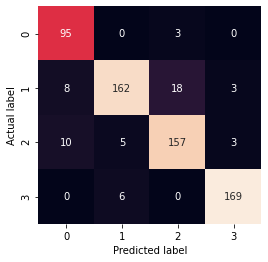

In [ ]:
def random_forest_parameters_tuning():
    n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
    max_features = ['auto', 'sqrt']
    max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
    max_depth.append(None)
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2, 4]
    bootstrap = [True, False]

    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    model = RandomForestClassifier()
    
    general_parameter_tuning(model, "Random Forest", random_grid)

random_forest_parameters_tuning()

Now we choose to fit the Random Forest model with the best hyperparameters that were achieved. <br>
From experimenting we saw that its accuracy was estimated between 90% to 93% in different executions which is excellent.

=============Random Forest=============
classification report: 

              precision    recall  f1-score   support

           0       0.81      0.94      0.87        94
           1       0.97      0.81      0.88       173
           2       0.89      0.95      0.92       186
           3       0.96      0.98      0.97       186

    accuracy                           0.92       639
   macro avg       0.91      0.92      0.91       639
weighted avg       0.92      0.92      0.92       639






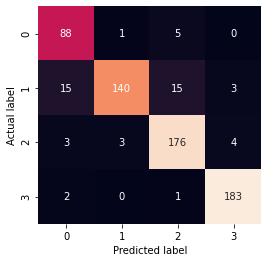

In [ ]:
def best_random_forest():
    model = RandomForestClassifier(n_estimators=600, min_samples_split=2, min_samples_leaf=2,
                                   max_features='auto', max_depth=60, bootstrap=False)
    fit_and_print(model, "Random Forest")
    return model

best_rf_model = best_random_forest()

From different executions of the Random Forest Hyperparameter Tuning, we found out one model that was not only good in general, but also had very high precision in the detection of Glioma. <br> In different executions it had between 98% to 100% precision in the Glioma class and we had an idea how we can use this property of the model to our advantage later in the notebook (with Hierarchical Classification).

=============Random Forest=============
classification report: 

              precision    recall  f1-score   support

           0       0.83      0.97      0.89        94
           1       0.97      0.82      0.89       173
           2       0.91      0.95      0.93       186
           3       0.96      0.98      0.97       186

    accuracy                           0.93       639
   macro avg       0.92      0.93      0.92       639
weighted avg       0.93      0.93      0.93       639






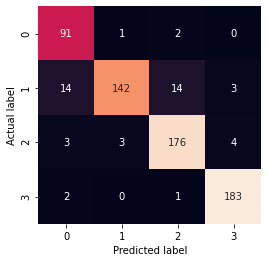

In [ ]:
def gilioma_forest_separator():
    global x_train, x_test, y_train, y_test
    # 98 precision in class 1
    model = RandomForestClassifier(n_estimators=900, min_samples_split=3, min_samples_leaf=2,
                                   max_features='sqrt', max_depth=90, bootstrap=False)
    fit_and_print(model, "Random Forest")
    return model

rf_separator = gilioma_forest_separator()

## <h3>Hyperparameter Tuning - Support Vector Machine</h3>
According to an article about brain tumor detection with ML techniques, SVM with rbf kernel performed with the highest score, even surpassing Deep Learning models like CNN. <br>
So now we will try to find the best combination of hyperparameters among 'C' and 'gamma'.



Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 11.1min finished


{'gamma': 0.001, 'C': 85}
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 11.0min finished


=============SVM=============
classification report: 

              precision    recall  f1-score   support

           0       0.85      0.82      0.83        98
           1       0.87      0.87      0.87       191
           2       0.84      0.86      0.85       175
           3       0.97      0.97      0.97       175

    accuracy                           0.89       639
   macro avg       0.88      0.88      0.88       639
weighted avg       0.89      0.89      0.89       639






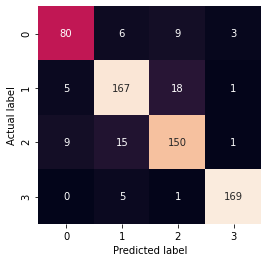

In [ ]:
def svm_parameters_tuning():
    param_grid = {'C': [0.1, 0.5, 1, 5, 15, 35, 75, 85, 100],
                  'gamma': [1.5, 0.5, 0.1, 0.01, 0.001],}
    model = SVC(kernel='rbf')

    # Fit the random grid search model
    general_parameter_tuning(model, "SVM", param_grid)

svm_parameters_tuning()

Anomaly Detection methods with algorithms like SVM or KNN:
Now we will try to use those methods with hyperparameter-tuning in order to try to achieve even better results than the greatest Random Forest.

=============SVM=============
classification report: 

              precision    recall  f1-score   support

           0       1.00      0.61      0.75        94
           1       0.86      0.76      0.81       173
           2       0.70      0.91      0.79       186
           3       0.98      0.99      0.98       186

    accuracy                           0.85       639
   macro avg       0.89      0.82      0.83       639
weighted avg       0.87      0.85      0.85       639






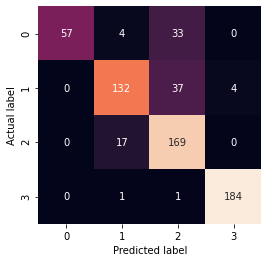

In [ ]:
def svm_separator():
    model = SVC(gamma=0.01, C=75)
    fit_and_print(model, "SVM")
    return model

svm_model = svm_separator()

The resulting SVM model turned out to be very interesting, first of all, unlike classic SVM models, this is a SVM model which isn't linear, it's kernel is called Radial Basis Function. <br>
When we used that kernel with high amount of 'C' and low amount of 'gamma' hyperparameters, we discovered a model that has 100% precision in classes 0, 2 and 3 but has only approximately 17% percent recall on each of them. <br> It turned out that this was because it has a very high amount of false positive in the gliomas (class 1). <br>
We would use this later and a stronger model that we built with Hierarchical Classification.

## Hyperparameter Tuning - KNN

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  4.4min finished


{'weights': 'distance', 'p': 2, 'n_neighbors': 5, 'metric': 'manhattan', 'leaf_size': 49}
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  4.4min finished


=============KNN=============
classification report: 

              precision    recall  f1-score   support

           0       0.86      0.85      0.86        98
           1       0.81      0.87      0.84       191
           2       0.85      0.77      0.80       175
           3       0.93      0.96      0.95       175

    accuracy                           0.86       639
   macro avg       0.86      0.86      0.86       639
weighted avg       0.86      0.86      0.86       639






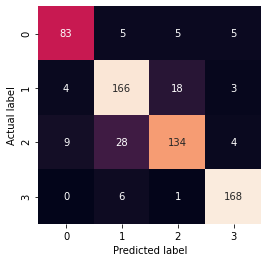

In [ ]:
def knn_parameters_tuning(x_train, x_test, y_train, y_test):
    leaf_size = list(range(1, 50))
    n_neighbors = [5, 7, 9, 11, 13, 15]
    weights = ['uniform', 'distance']
    metric = ['minkowski', 'euclidean', 'manhattan']

    p = [1, 2]
    # Convert to dictionary
    param_grid = {'leaf_size': leaf_size, 
                  'n_neighbors': n_neighbors,
                  'p': p,
                  'weights': weights, 
                  'metric': metric,}
    model = KNeighborsClassifier()
    
    general_parameter_tuning(model, "KNN", param_grid)

knn_parameters_tuning(x_train, x_test, y_train, y_test)

After running the function that will perform the hyperparameter-tuning we chose the following model:

=============KNN=============
classification report: 

              precision    recall  f1-score   support

           0       0.77      0.90      0.83        94
           1       0.76      0.90      0.82       173
           2       0.93      0.70      0.80       186
           3       1.00      0.98      0.99       186

    accuracy                           0.87       639
   macro avg       0.86      0.87      0.86       639
weighted avg       0.88      0.87      0.87       639






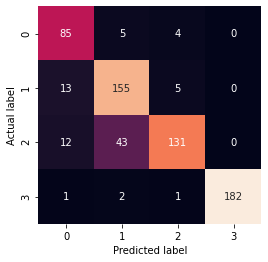

In [ ]:
def knn_separator():
    # 87% accuracy
    model = KNeighborsClassifier(p=1, n_neighbors=2, leaf_size=9)
    fit_and_print(model, "KNN")
    return model

knn_model = knn_separator()

As we can see this KNN model, even though his accuracy is not better than the Random Forest that we found. <br> 
It has a very high precision rate in pituitary's class (class 3) so we could use it later for our advantage.

# Hierarchical Classification
Now we will try to use Hierarchical Classification which is a technique that involves using several models, one after another in different scenarios or finishing early in some cases. <br>
All the models should be fitted first and on the same training samples, and then this classifier will make predictions only. <br>
In our case we will be using SVM, KNN and two different Random Forest models. 
<br>
The following diagram represents how our Hierarchical Classifier will work.

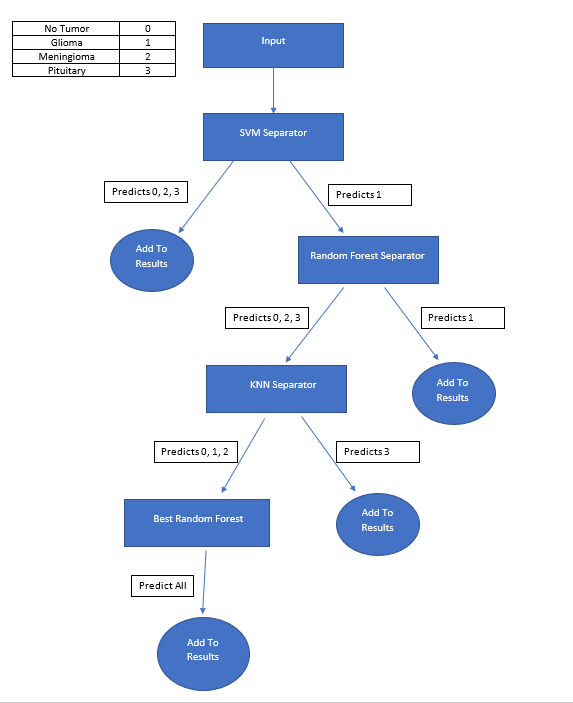

The following function is used to split the test samples according to a model's predictions. <br>
This is done in order to know if we should add samples to results or to pass them to the next model in the row. <br>
The decision of which to pass and which not is based solely on the prediction value of the previous model and not on the y_test tags.

In [ ]:
def select_predictions(x_test, y_test, predict, trusted_tags):
    trusted_pred = [(y, pred) for (y, pred) in zip(y_test, predict) 
                    if pred in trusted_tags]
    untrusted_pred = [(x, y) for (x, y, pred) in zip(x_test, y_test, predict) 
                      if pred not in trusted_tags]
    return trusted_pred, untrusted_pred

We implemented the Hierarchical Classifier with a function that accepts a list of fitted models, and for each model (except for the last) there is the list of tags that the model has a very high precision on it. 
We also add the test samples and their tags. <br>
In the function we created 2 arrays that represents what are the current x_test and y_test (with the variables chained_x_test, chained_y_test correspondingly), and 2 variables that represents the predictions that were added so far to the total results of the classification. <br>
Then each model makes the predictions and we add selectively only those with high likelihood to be correct. At the end we print the classification report and confusion matrix of this classifier.  

In [ ]:
def hierarchical_classifying(models, trusted_tags_array, x_test, y_test):
    chained_x_test, chained_y_test = x_test.copy(), y_test.copy()
    new_y_test, new_predict = [], []
    for index, model in enumerate(models[:-1]):
        predict = model.predict(chained_x_test)
        trusted_pred, untrusted_pred = select_predictions(chained_x_test, chained_y_test,
                                                          predict, trusted_tags_array[index])
        new_y_test += [item[0] for item in trusted_pred]
        new_predict += [item[1] for item in trusted_pred]

        chained_x_test = [item[0] for item in untrusted_pred]
        chained_y_test = [item[1] for item in untrusted_pred]


    last_model_predict = models[-1].predict(chained_x_test)
    new_y_test += chained_y_test
    new_predict += last_model_predict.tolist()

    print(classification_report(new_y_test, new_predict))
    conf_mat = confusion_matrix(new_y_test, new_predict)
    plot_conf_mat(conf_mat)


In the following section we can see that each model in the chain has tags did he classifies with very high precision, therefore we've decided to store those "trusted tags" of each model in order to equip it to the Hierarchical Classifier. 

              precision    recall  f1-score   support

           0       1.00      0.64      0.78        94
           1       0.98      0.73      0.84       173
           2       0.70      0.98      0.82       186
           3       0.97      0.99      0.98       186

    accuracy                           0.87       639
   macro avg       0.91      0.84      0.85       639
weighted avg       0.90      0.87      0.87       639



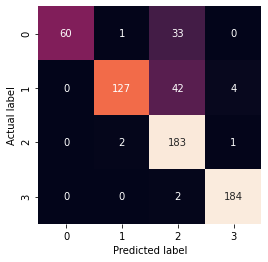

In [ ]:
svm_trusted_tags = [0, 2, 3]
rf_separator_trusted_tags = [1]
knn_trusted_tags = [3]
trusted_tags_array = [svm_trusted_tags, rf_separator_trusted_tags, knn_trusted_tags]

models = [svm_model, rf_separator, knn_model, best_rf_model]
hierarchical_classifying(models, trusted_tags_array, x_test, y_test)

<h3>Conclusions about the Hierarchical classifier</h3>
As we can see this classifier was slightly less accurate than the best Random Forest model that was discovered previously. <br>
Although this type of classification did not show a major change in results, we are glad to say that it was worth the try because we learned a lot in the process. We found out that some classifiers had between 98% to 100% to certain classes in we've used it to build some form of a large, chained classifier that combines them all (it is somewhat similar to ensemble learning).

# Classify with CNN - Second attempt


We already noticed that data shuffling gave significant performance improvement in the diverse Keras models (i.e., Random Forest, KNN...) <br>
So this will be the first thing we will change to improve our CNN performance. <br>


First, we will copy the dataset in its original form as it first loaded. <br>
Then we are shuffling the data to 80% training and 20% testing.  

In [ ]:
x_train, y_train = X_train.copy(), Y_train.copy()
x_test, y_test = X_test.copy(), Y_test.copy()
x_train, x_test, y_train, y_test = shuffle_data(x_train, x_test, y_train, y_test)
x_train, x_test, y_train, y_test = adjust_dataset_to_CNN(x_train, x_test, y_train, y_test)

Image for example:

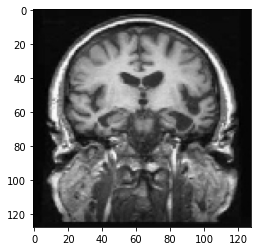

In [ ]:
plt.imshow(x_train[9], cmap='gray')

Now we will train again the CNN to check for possible improvement.

We thought on ways to improve our model and we came up with callback.<br>
Callback are objects that can perform some actions at various stages of the training. <br>
We chose to use EarlyStopping and ModelCheckpoint. <br>
EarlyStopping records the model performances between epoch, compare them, and in the end of every epoch decide if the model will continue the training or stop it. <br>
We chose validation accuracy to be the stopping criteria.<br>
If ther won't be any improvement at the validation accuracy for 8 epoch in a row we will stop the training. <br>
In that way we try to prevent overfitting.<br>
Another callback we use is Checkpoint.<br>
With Checkpoint we are recording the model weights in every epoch that improved the validation accuracy.<br>
And so we save the best configuration of the model even if it wasn't the last training epoch, and after training phase is over we are load them back to maximize the validation accuracy.

In [ ]:
early_stop = EarlyStopping(
    monitor='val_accuracy', 
    patience=8,
    mode='auto',
)
cache = "saved_models/best_conf.ckpt"
checkpoint = ModelCheckpoint(cache,
                             monitor='val_accuracy',
                             verbose=False,
                             save_best_only=True,
                             save_weights_only=True,
                             mode='max')

In [ ]:
model = Sequential(
        [
            Convolution2D(32, (3,3), activation ='relu', input_shape = (128, 128, 1)),
            MaxPooling2D(pool_size=2),
            
            Convolution2D(filters=64, kernel_size=4, padding='same', activation='relu'),
            MaxPooling2D(pool_size=2),
            
            Convolution2D(filters=128, kernel_size=3, padding='same', activation='relu'),
            MaxPooling2D(pool_size=2),
            
            Convolution2D(filters=128, kernel_size=2, padding='same', activation='relu'),
            MaxPooling2D(pool_size=2),
            Dropout(0.25), 
            
            Flatten(),
            Dense(units=128,activation = 'relu'),
            
            Dense(units = 64, activation = 'relu'),
            Dense(units = 32, activation = 'relu'),
            Dense(units = 4, activation = 'softmax')
        ]
    )

In [ ]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [ ]:
history = model.fit(x_train,y_train,
                    epochs=50, 
                    callbacks=[checkpoint, early_stop],
                    validation_data=(x_test,y_test),
                    verbose = False)
model.load_weights("saved_models/best_conf.ckpt")

20/20 [==============================] - 1s 69ms/step - loss: 0.2976 - accuracy: 0.9280


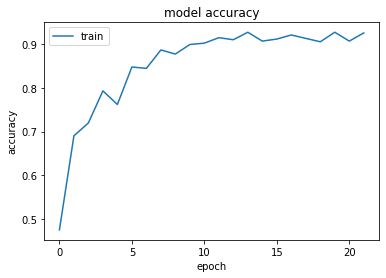

In [ ]:
model.evaluate(x_test,y_test)
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

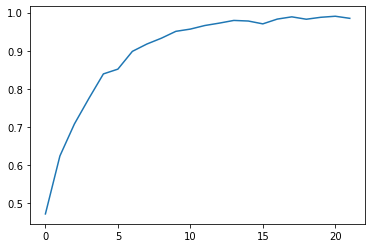

In [ ]:
plt.plot(history.history['accuracy'])

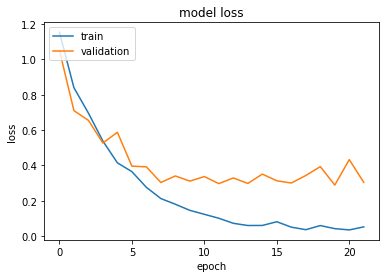

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
y_predicted = model.predict_classes(x_test)
# Get back from catagorical to lables
y_actual = np.argmax(y_test,axis=1) 

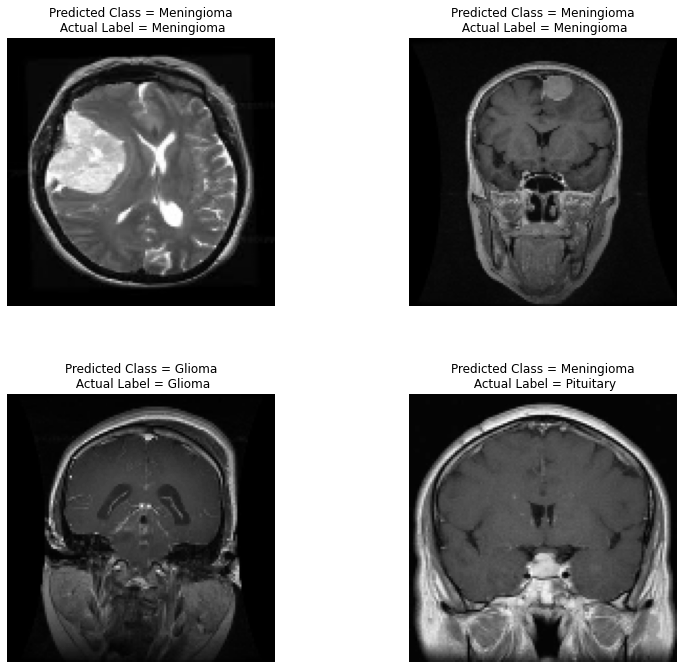

In [ ]:
plot_classified_images(x_test, y_predicted, y_actual)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_actual, y_predicted))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94        94
           1       0.92      0.91      0.92       185
           2       0.87      0.91      0.89       178
           3       0.98      0.97      0.98       182

    accuracy                           0.93       639
   macro avg       0.93      0.93      0.93       639
weighted avg       0.93      0.93      0.93       639



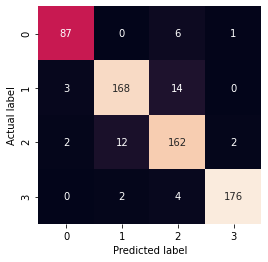

In [ ]:
conf_mat = confusion_matrix(y_actual, y_predicted)
plot_conf_mat(conf_mat)  

By data shuffling  we improved the CNN accuracy to 0.94 (0.94487 to be precise) which is the best result we got till now.

# Smoothing

The change we apply here is smoothing all the images with gaussian filter. <br>
According to this article: <br>
El Kader Isselmou, A., Xu, G., Zhang, S., Saminu, S., & Javaid, I. (2019, July). Deep learning algorithm for brain tumor detection and analysis using MR brain images. In Proceedings of the 2019 International Conference on Intelligent Medicine and Health (pp. 28-32).<br>

It's common to apply Gaussian filter to remove noises in medical images due to their high sensitivity to high frequency. <br>
In addition, we wand the model to ignore irrelevant information that hides in the brain and just find the general form of the tumor itself, so blurring may help here. 

In [ ]:
x_train, y_train = X_train.copy(), Y_train.copy()
x_test, y_test = X_test.copy(), Y_test.copy()
x_train, x_test, y_train, y_test = shuffle_data(x_train, x_test, y_train, y_test)

Before smoothing, just to get sense of what is happening here, here we can see an original image 

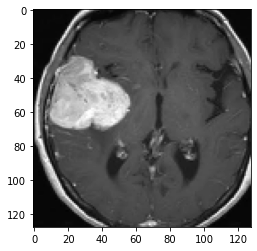

In [ ]:
plt.imshow(x_train[25], cmap="gray")

In [ ]:
for i, img in enumerate(x_train):
    x_train[i] = cv2.GaussianBlur(img,(3,3),0)

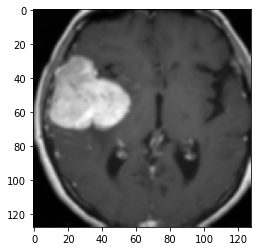

In [ ]:
plt.imshow(x_train[25], cmap='gray')

Then we will adjust the dataset array for the CNN model.

In [ ]:
x_train, x_test, y_train, y_test = adjust_dataset_to_CNN(x_train, x_test, y_train, y_test)

In [ ]:
print(x_train.shape)
print(x_test.shape)

(2556, 128, 128, 1)
(639, 128, 128, 1)


Now we will train again the CNN to check for possible improvement.

In [ ]:
early_stop = EarlyStopping(
    monitor='val_accuracy', 
    patience=8,
    mode='auto',
)
cache = "saved_models/best_conf.ckpt"
checkpoint = ModelCheckpoint(cache,
                             monitor='val_accuracy',
                             verbose=False,
                             save_best_only=True,
                             save_weights_only=True,
                             mode='max')

In [ ]:
smoothed_model = Sequential(
        [
            Convolution2D(32, (3,3), activation ='relu', input_shape = (128, 128, 1)),
            MaxPooling2D(pool_size=2),
            
            Convolution2D(filters=64, kernel_size=4, padding='same', activation='relu'),
            MaxPooling2D(pool_size=2),
            
            Convolution2D(filters=128, kernel_size=3, padding='same', activation='relu'),
            MaxPooling2D(pool_size=2),
            
            Convolution2D(filters=128, kernel_size=2, padding='same', activation='relu'),
            MaxPooling2D(pool_size=2),
            Dropout(0.25), 
            
            Flatten(),
            Dense(units=128,activation = 'relu'),
            
            Dense(units = 64, activation = 'relu'),
            Dense(units = 32, activation = 'relu'),
            Dense(units = 4, activation = 'softmax')
        ]
    )

In [ ]:
smoothed_model.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [ ]:
history = smoothed_model.fit(x_train,y_train,
                    epochs=50, 
                    callbacks=[checkpoint, early_stop],
                    validation_data=(x_test,y_test),
                    verbose = False)
smoothed_model.load_weights("saved_models/best_conf.ckpt")

30/30 [==============================] - 2s 70ms/step - loss: 0.0685 - accuracy: 0.9864


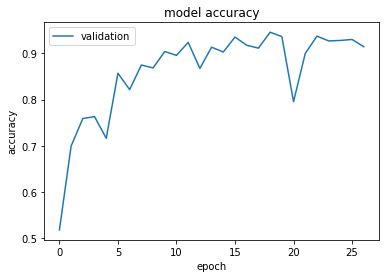

In [ ]:
smoothed_model.evaluate(x_test,y_test)
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['validation'], loc='upper left')
plt.show()

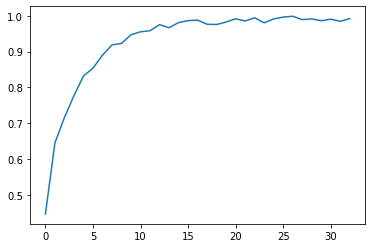

In [ ]:
plt.plot(history.history['accuracy'])

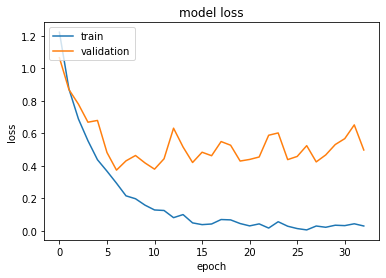

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
y_predicted = smoothed_model.predict_classes(x_test)
# Get back from catagorical to lables
y_actual = np.argmax(y_test,axis=1) 

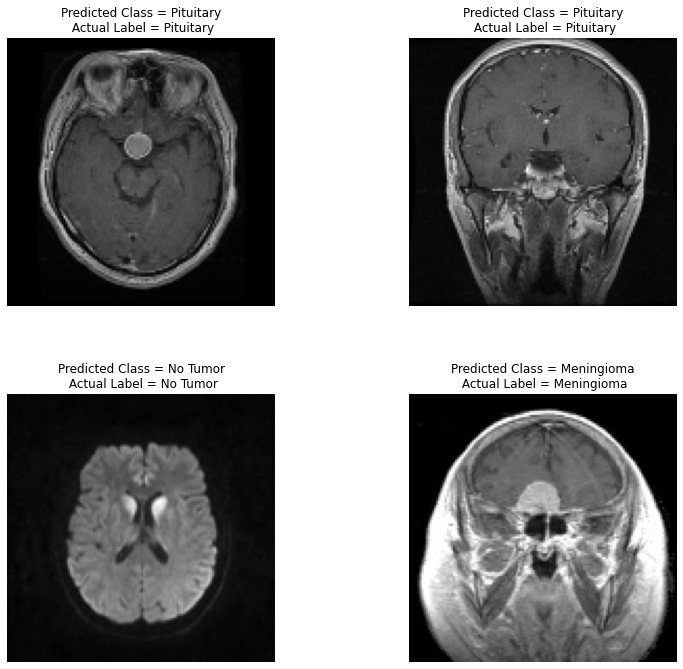

In [ ]:
plot_classified_images(x_test, y_predicted, y_actual)

In [ ]:
print(classification_report(y_actual, y_predicted))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93        93
           1       0.96      0.85      0.90       184
           2       0.90      0.95      0.92       186
           3       0.96      1.00      0.98       176

    accuracy                           0.93       639
   macro avg       0.93      0.94      0.93       639
weighted avg       0.94      0.93      0.93       639



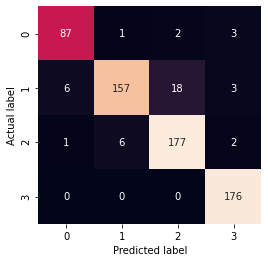

In [ ]:
conf_mat = confusion_matrix(y_actual, y_predicted)
plot_conf_mat(conf_mat)  

Its a little improvement from the previous running but still the same accuracy - 93%
We must mention that it's a little surprising result because we expected the CNN to learn the weights of the best kernels needed and if Gaussian kernel is good - we expected the network to learn and apply it, we assume this preprocessing  method enabled the network to focus on more important kernels. 

# Data augmentation

We did research for some work that is similarly to ours so we could try to reproduce it and we found this article: 
<a href="https://doi.org/10.3390/app10061999"> (Badža & Barjaktarović, 2020)</a>. <br>
They described a different CNN architecture to classify images into 3 classes of brain tumor.
Glioma, meningioma and pituitary. They didn't have "No tumor" class like us but it's pretty similar to our goal. 
They had 3064 gray scale MRI images in deferent sizes, so as we did before they resized the images to 256*256 and normalized their values. <br>
In addition they augmented their dataset three times by applying, to each image, vertical flip and 90 degrees rotation to get two new copies for each image. <br>
We wanted to reproduce their very high results.<br>
Their model is described blow in this chapter. <br>
In addition, we tried to get their data augmentation approach and make it more stochastic to get more independent and unexpected images.<br>
But unfortunately, we didn't succeeded to make the stochastic, on the flow, data augmentation work. and even worse - their CNN model didn't come to any significant result.<br>
Yet, we decided to show the code and their CNN architecture, and in the next chapter we will combine between their deterministic data augmentation technique and our CNN model. <br>


In [ ]:
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from skimage import io
from PIL import Image

In [ ]:
data_generator = ImageDataGenerator(
    vertical_flip=True,
    horizontal_flip=True,
    rotation_range=135,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=[0.8, 1.2],
    fill_mode='constant', cval=0
)

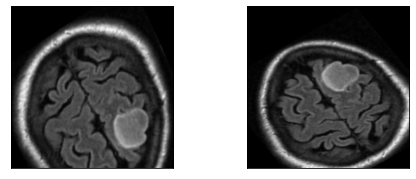

In [ ]:
img1 = io.imread("Testing/glioma_tumor/image(100).jpg")
img = img_to_array(img)
img1 = np.expand_dims(img, axis=0)
data_gen_flow = data_generator.flow(img1,batch_size=88)
 
# Display some augmented samples
plt.figure(figsize=(10,5))
for i in range(2):
    plt.subplot(2,3,i+1)
    for x in data_gen_flow:
        plt.imshow(x[0]/255.)
        plt.xticks([])
        plt.yticks([])
        break
plt.tight_layout()
plt.show()

(1, 256, 256, 3)
uint8


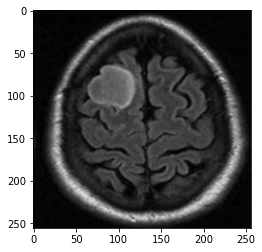

In [ ]:
os.chdir(root_dir)
dataset = []
image = io.imread("Testing/glioma_tumor/image(100).jpg")
image = Image.fromarray(image, 'RGB')
image = image.resize((256,256))
dataset.append(np.array(image))
x = np.array(dataset)
x.shape
print(x.shape)
print(x.dtype)
plt.imshow(image)

In [ ]:
print(type(x))
i=0
for batch in data_generator.flow(x,
                                 batch_size=16,
                                 save_to_dir='augmented',
                                 save_prefix='aug',
                                 save_format='jpg'):
    print(batch.shape)
    print(batch.size)
    i+=1
    if i > 0:
        break

<class 'numpy.ndarray'>
(1, 256, 256, 3)
196608


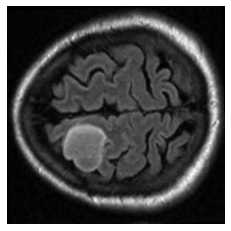

In [ ]:
augmented_images = os.listdir("augmented")
img = cv2.imread(f"augmented/{augmented_images[-1]}")
plt.imshow(img, cmap="gray")
plt.axis('off')
plt.show()


In [ ]:
x_train, y_train = X_train.copy(), Y_train.copy()
x_test, y_test = X_test.copy(), Y_test.copy()
x_train, x_test, y_train, y_test = adjust_dataset_to_CNN(
                                                    x_train, 
                                                    x_test,
                                                    y_train, 
                                                    y_test)

In [ ]:
from tensorflow.keras import initializers, regularizers
gln = tf.keras.initializers.GlorotNormal() 

This is the model structure as described in the article.<br>
Note that Glorot is anyway the default initializer in keras layers.

In [ ]:
model = Sequential(
        [
            Convolution2D(filters=16, strides=(2,2), kernel_size=5, activation ='relu', input_shape = (128, 128,1), kernel_initializer=gln),
            Dropout(0.5),
            MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'),
            
            Convolution2D(filters=32, kernel_size=3, padding='same', activation='relu',kernel_initializer=gln),
            Dropout(0.5),
            MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'),
            
            Convolution2D(filters=64, strides=(1,1), kernel_size=3, padding='same', activation='relu',kernel_initializer=gln),
            Dropout(0.5),
            MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'),
            
            Convolution2D(filters=128, strides=(1,1), kernel_size=3, padding='same', activation='relu',kernel_initializer=gln, bias_initializer="zeros"),
            Dropout(0.5),
            MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'),
         
            Flatten(),
            
            Dense(units=1024, activation = 'relu'),
            Dense(units = 4, activation = 'relu'),
            Dense(units = 4, activation = 'softmax')
        ]
    )
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 62, 62, 16)        416       
_________________________________________________________________
dropout_3 (Dropout)          (None, 62, 62, 16)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 31, 31, 32)        4640      
_________________________________________________________________
dropout_4 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 64)       

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stop = EarlyStopping(
    monitor='val_accuracy', 
    patience=5,
    mode='auto',
)
cache = "saved_models/augmented/best_conf.ckpt"
checkpoint = ModelCheckpoint(cache,
                             monitor='val_accuracy',
                             verbose=True,
                             save_best_only=True,
                             save_weights_only=True,
                             mode='max')

In [ ]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [ ]:
training_gen = data_generator.flow(
    x_train,
    y_train,
    batch_size=3,
    shuffle=True,
    )
validation_gen= data_generator.flow(
    x_test,
    y_test,
    batch_size=3,
    shuffle=True,
)

In [ ]:

history = model.fit_generator(training_gen,
                    epochs=50,
                    steps_per_epoch=2850//3,
                    validation_data=validation_gen,
                    validation_steps=700//3,
                    callbacks=[early_stop, checkpoint],
                    verbose=True)

# Deterministic Data Augmentation

Now we have back with the deterministic data augmentation approach.<br>
In doing so, we expose our model to different views of the same problem and thus improve its generalization ability and make it more robust.

As usual, we are coping the clear images and split it randomly to train and test.
But now, we are augmenting the training images so we can afford to split it to 70% training and 30% testing.<br>
We are not augmenting the test images because it might will hurt the truth of the results.

In [ ]:
x_train, y_train = X_train.copy(), Y_train.copy()
x_test, y_test = X_test.copy(), Y_test.copy()
x_train, x_test, y_train, y_test = shuffle_data(x_train, x_test, y_train, y_test, test_size=0.3)

In [ ]:
vflip_train = []
rot_train = []
for img in x_train:
    vertical_flip = cv2.flip(img, 0)
    vflip_train.append(vertical_flip)
    rotate_90 = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    rot_train.append(rotate_90)

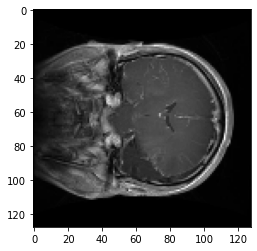

In [ ]:
plt.imshow(rot_train[16], cmap="gray")

And combine them all to on test and train sets. The new images has the same y value as the images the were generated from and the images order didn't change so the y_train and y_test is still true classification of the images in vflip_test, rot_test, vflip_train, rot_train correspondingly.
So, in order to save the y values of the rotated and flipped images we just need to combine x_train, vflip_train, rot_train  and append the y_train to itself two times (and to do the same with the tests)

In [ ]:
x_train = x_train + rot_train + vflip_train
y_train = y_train + y_train + y_train

In [ ]:
x_train, x_test, y_train, y_test = adjust_dataset_to_CNN(x_train, x_test, y_train, y_test)

In [ ]:
early_stop = EarlyStopping(
    monitor='val_accuracy', 
    patience=8,
    mode='auto',
)
cache = "saved_models/best_conf.ckpt"
checkpoint = ModelCheckpoint(cache,
                             monitor='val_accuracy',
                             verbose=False,
                             save_best_only=True,
                             save_weights_only=True,
                             mode='max')

In [ ]:
model = Sequential(
        [
            Convolution2D(32, (3,3), activation ='relu', input_shape = (128, 128,1)),
            MaxPooling2D(pool_size=2),
            
            Convolution2D(filters=64, kernel_size=4, padding='same', activation='relu'),
            MaxPooling2D(pool_size=2),
            
            Convolution2D(filters=128, kernel_size=3, padding='same', activation='relu'),
            MaxPooling2D(pool_size=2),
            
            Convolution2D(filters=128, kernel_size=2, padding='same', activation='relu'),
            BatchNormalization(),
            MaxPooling2D(pool_size=2),
            Dropout(0.25),
            
            Flatten(),

            Dense(units=128,activation = 'relu'),
            Dropout(0.25),
            
            Dense(units = 64, activation = 'relu'),
            Dense(units = 32, activation = 'relu'),
            Dense(units = 4, activation = 'softmax')
        ]
    )

In [ ]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [ ]:
history = model.fit(x_train,y_train,
                    epochs=50, 
                    callbacks=[checkpoint, early_stop],
                    validation_data=(x_test,y_test),
                    verbose = False,
                    shuffle=True)


Epoch 00001: val_accuracy improved from -inf to 0.51825, saving model to saved_models\best_conf.ckpt

Epoch 00002: val_accuracy improved from 0.51825 to 0.69969, saving model to saved_models\best_conf.ckpt

Epoch 00003: val_accuracy improved from 0.69969 to 0.75912, saving model to saved_models\best_conf.ckpt

Epoch 00004: val_accuracy improved from 0.75912 to 0.76330, saving model to saved_models\best_conf.ckpt

Epoch 00005: val_accuracy did not improve from 0.76330

Epoch 00006: val_accuracy improved from 0.76330 to 0.85714, saving model to saved_models\best_conf.ckpt

Epoch 00007: val_accuracy did not improve from 0.85714

Epoch 00008: val_accuracy improved from 0.85714 to 0.87487, saving model to saved_models\best_conf.ckpt

Epoch 00009: val_accuracy did not improve from 0.87487

Epoch 00010: val_accuracy improved from 0.87487 to 0.90407, saving model to saved_models\best_conf.ckpt

Epoch 00011: val_accuracy did not improve from 0.90407

Epoch 00012: val_accuracy improved from 0.9

In [ ]:
model.load_weights("saved_models/best_conf.ckpt")

30/30 [==============================] - 2s 72ms/step - loss: 0.2136 - accuracy: 0.9458


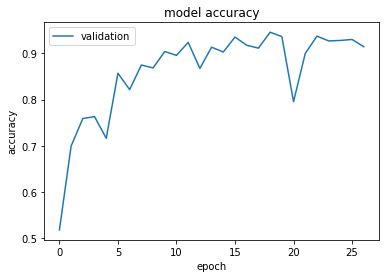

In [ ]:
model.evaluate(x_test,y_test)
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['validation'], loc='upper left')
plt.show()

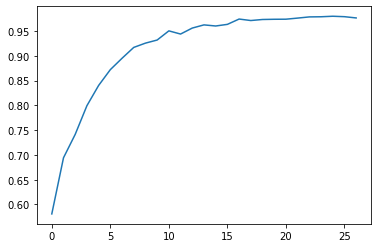

In [ ]:
plt.plot(history.history['accuracy'])

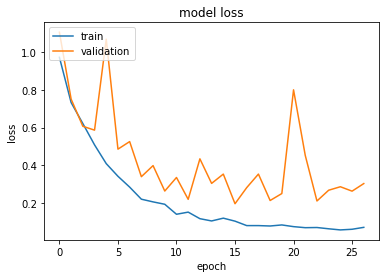

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

<p>Preparing the data to analysis</p>

In [ ]:
y_predicted = model.predict_classes(x_test)
# Get back from catagorical to lables
y_actual = np.argmax(y_test,axis=1) 

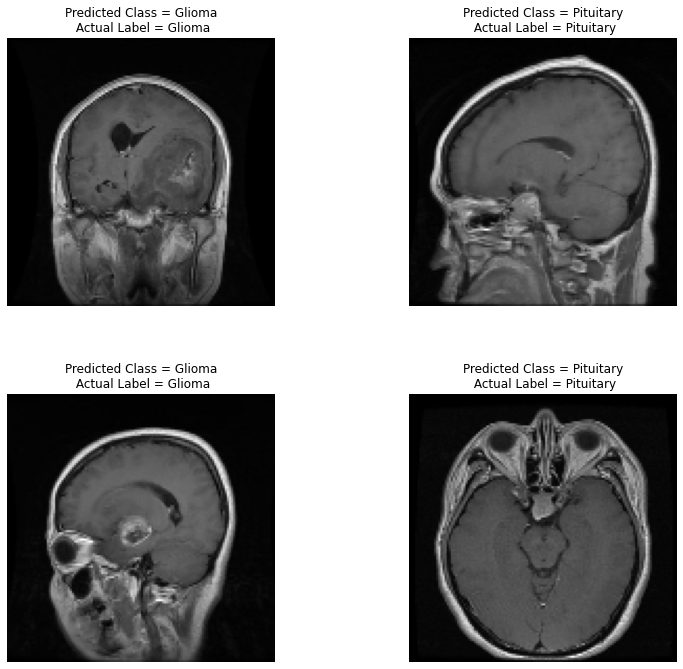

In [ ]:
plot_classified_images(x_test, y_predicted, y_actual)

<h6>Classification results examples</h6>

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_actual, y_predicted))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       150
           1       0.93      0.94      0.93       277
           2       0.94      0.92      0.93       256
           3       0.99      0.98      0.99       276

    accuracy                           0.95       959
   macro avg       0.94      0.94      0.94       959
weighted avg       0.95      0.95      0.95       959



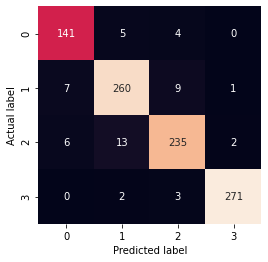

In [ ]:
conf_mat = confusion_matrix(y_actual, y_predicted)
plot_conf_mat(conf_mat)   


So after all the mentioned article indeed was useful and helped us get to 95% accuracy with very high results on the Pituitary class!

# Combine smoothing, data augmentation

In addition for this combination, a new technique we will first use here is Batch normalization. <br>
This method normalize weights of the neurons after every batch. it's known for improving the speed performance and stability of the learning. <br>

In [ ]:
x_train, y_train = X_train.copy(), Y_train.copy()
x_test, y_test = X_test.copy(), Y_test.copy()
x_train, x_test, y_train, y_test = shuffle_data(x_train, x_test, y_train, y_test, test_size=0.3)

In [ ]:
for i, img in enumerate(x_train):
    x_train[i] = cv2.GaussianBlur(img,(3,3),0) 

In [ ]:
vflip_train = []
rot_train = []
for img in x_train:
    vertical_flip = cv2.flip(img, 0)
    vflip_train.append(vertical_flip)
    rotate_90 = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    rot_train.append(rotate_90)

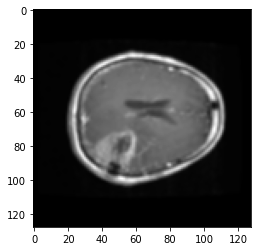

In [ ]:
plt.imshow(rot_train[100], cmap='gray')

And combine them all to on test and train sets,
the new images has the same y value as the images the were generated from and the images order didn't change so the y_train and y_test is still true classification of the images in vflip_test, rot_test, vflip_train, rot_train correspondingly.
So, in order to save the y values of the rotated and flipped images we just need to combine x_train, vflip_train, rot_train  and append the y_train to itself two times (and to do the same with the tests)

In [ ]:
x_train = x_train + rot_train + vflip_train
y_train = y_train + y_train + y_train

In [ ]:
x_train, x_test, y_train, y_test = adjust_dataset_to_CNN(x_train, x_test, y_train, y_test)
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.reshape(x_test.shape + (1,))

In [ ]:
early_stop = EarlyStopping(
    monitor='val_accuracy', 
    patience=8,
    mode='auto',
)
cache = "saved_models/best_conf.ckpt"
checkpoint = ModelCheckpoint(cache,
                             monitor='val_accuracy',
                             verbose=True,
                             save_best_only=True,
                             save_weights_only=True,
                             mode='max')

In [ ]:
model = Sequential(
        [
            Convolution2D(32, (3,3), activation ='relu', input_shape = (128, 128, 1)),
            MaxPooling2D(pool_size=2),
            
            Convolution2D(filters=64, kernel_size=4, padding='same', activation='relu'),
            MaxPooling2D(pool_size=2),
            
            Convolution2D(filters=128, kernel_size=3, padding='same', activation='relu'),
            BatchNormalization(),
            MaxPooling2D(pool_size=2),
            Dropout(0.25), 
            
            Convolution2D(filters=128, kernel_size=2, padding='same', activation='relu'),
            MaxPooling2D(pool_size=2),
            Dropout(0.25), 
            Flatten(),
            
            Dense(units=128,activation = 'relu'),
            BatchNormalization(),
            Dropout(0.25), 
            Dense(units = 64, activation = 'relu'),
            Dense(units = 32, activation = 'relu'),
            Dense(units = 4, activation = 'softmax')
        ]
    )

In [ ]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])

We have now more training data do we can set the batch size to high value.

In [ ]:
history = model.fit(x_train,y_train,
                    epochs=50, 
                    callbacks=[checkpoint, early_stop],
                    validation_data=(x_test,y_test),
                    verbose = False,
                    shuffle=True,
                    batch_size=64)


Epoch 00001: val_accuracy improved from -inf to 0.27424, saving model to saved_models\best_conf.ckpt

Epoch 00002: val_accuracy did not improve from 0.27424

Epoch 00003: val_accuracy improved from 0.27424 to 0.38895, saving model to saved_models\best_conf.ckpt

Epoch 00004: val_accuracy did not improve from 0.38895

Epoch 00005: val_accuracy improved from 0.38895 to 0.63504, saving model to saved_models\best_conf.ckpt

Epoch 00006: val_accuracy improved from 0.63504 to 0.81022, saving model to saved_models\best_conf.ckpt

Epoch 00007: val_accuracy improved from 0.81022 to 0.81960, saving model to saved_models\best_conf.ckpt

Epoch 00008: val_accuracy improved from 0.81960 to 0.84880, saving model to saved_models\best_conf.ckpt

Epoch 00009: val_accuracy did not improve from 0.84880

Epoch 00010: val_accuracy improved from 0.84880 to 0.87487, saving model to saved_models\best_conf.ckpt

Epoch 00011: val_accuracy improved from 0.87487 to 0.90198, saving model to saved_models\best_conf.

In [ ]:
model.load_weights("saved_models/best_conf.ckpt")

30/30 [==============================] - 2s 75ms/step - loss: 0.2305 - accuracy: 0.9291


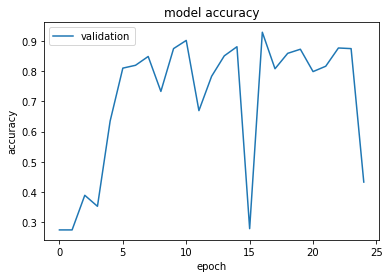

In [ ]:
model.evaluate(x_test,y_test)
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['validation'], loc='upper left')
plt.show()

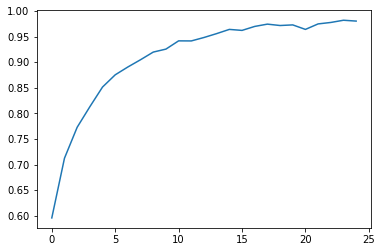

In [ ]:
plt.plot(history.history['accuracy'])

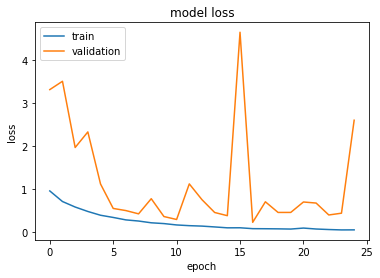

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

<p>Preparing the data to analysis</p>

In [ ]:
y_predicted = model.predict_classes(x_test)
# Get back from catagorical to lables
y_actual = np.argmax(y_test,axis=1) 

<h6>Classification results examples</h6>

In [ ]:
print(classification_report(y_actual, y_predicted))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91       143
           1       0.91      0.95      0.93       282
           2       0.96      0.87      0.91       271
           3       0.95      0.95      0.95       263

    accuracy                           0.93       959
   macro avg       0.92      0.93      0.93       959
weighted avg       0.93      0.93      0.93       959



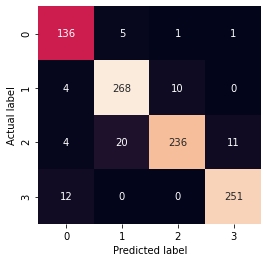

In [ ]:
conf_mat = confusion_matrix(y_actual, y_predicted)
plot_conf_mat(conf_mat)    


This time we saw improvement in the precision of the Meningioma class but all the others didn't performed as before. We think that the smoothing addition disturbed here. 

# Hierarchical Classification with CNN

## Tumor detection
Now, after we have a model with 95% accuracy and it's point of weak is class 0 - no tumor with precision of 0.89, 
we will first check if the image is even have a tumor and then check what type of a tumor is has. 

Shuffle to train and test with 20% to tests <br>
From now till the end of this part, we will use this specific shuffle to avoid testing the final hierarchical classifier with data that some of its models trained on.

In [ ]:
X_train, X_test, Y_train, Y_test = shuffle_data(X_train, X_test, Y_train, Y_test)
x_train, y_train = X_train.copy(), Y_train.copy()
x_test, y_test = X_test.copy(), Y_test.copy()

Redefine the classes 1, 2, 3 which are all the tumor types to class 1 that will represent the class of images that has some type of tumor in them. <br>
Class 0 - No Tumor. <br> 
Class 1 - Tumor.


In [ ]:
y_train = np.array(y_train, dtype="int64")
y_train = np.where(y_train>0 , 1, y_train) 


In [ ]:
y_test = np.array(y_test, dtype="int64")
y_test = np.where(y_test>0 , 1, y_test) 

In [ ]:
for i, img in enumerate(x_train):
    x_train[i] = cv2.GaussianBlur(img,(3,3),0) 

Adjust to CNN

In [ ]:
x_train = np.array(x_train)
x_test = np.array(x_test)

x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.reshape(x_test.shape + (1,))

y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)

In [ ]:
early_stop = EarlyStopping(
    monitor='val_accuracy', 
    patience=10,
    mode='auto',
)
cache = "saved_models/best_conf.ckpt"
checkpoint = ModelCheckpoint(cache,
                             monitor='val_accuracy',
                             verbose=False,
                             save_best_only=True,
                             save_weights_only=True,
                             mode='max')

In [ ]:
tumor_detection_model = Sequential(
        [
            Convolution2D(32, (3,3), activation ='relu', input_shape = (128, 128, 1)),
            MaxPooling2D(pool_size=2),
            
            Convolution2D(filters=64, kernel_size=4, padding='same', activation='relu'),
            MaxPooling2D(pool_size=2),
            
            Convolution2D(filters=128, kernel_size=3, padding='same', activation='relu'),
            MaxPooling2D(pool_size=2),
            
            Convolution2D(filters=128, kernel_size=2, padding='same', activation='relu'),
            BatchNormalization(),
            MaxPooling2D(pool_size=2),
            Dropout(0.25),
            
            Flatten(),
            Dense(units=128,activation = 'relu'),
            Dropout(0.25), 
            Dense(units = 64, activation = 'relu'),
            Dense(units = 32, activation = 'relu'),
            Dense(units = 2, activation = 'softmax')
        ]
    )

In [ ]:
tumor_detection_model.compile(optimizer='adam', loss = 'binary_crossentropy',metrics = ['accuracy'])

In [ ]:
tumor_detection_history = tumor_detection_model.fit(x_train,y_train,
                    epochs=50, 
                    callbacks=[checkpoint, early_stop],
                    validation_data=(x_test,y_test),
                    verbose = False,
                    shuffle=True)

In [ ]:
tumor_detection_model.load_weights("saved_models/best_conf.ckpt")

In [ ]:
y_predicted = tumor_detection_model.predict_classes(x_test)
# Get back from catagorical to lables
y_actual = np.argmax(y_test,axis=1) 

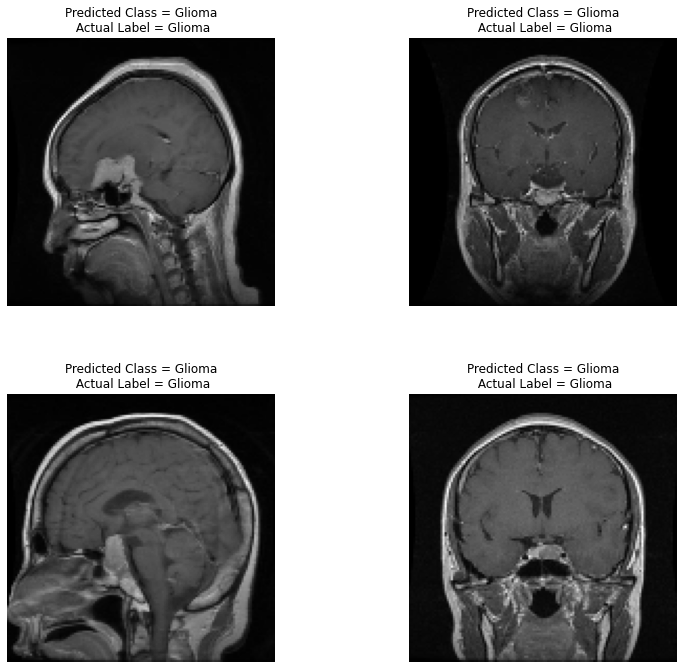

In [ ]:
plot_classified_images(x_test, y_predicted, y_actual)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_actual, y_predicted))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92        89
           1       0.99      0.99      0.99       550

    accuracy                           0.98       639
   macro avg       0.96      0.95      0.95       639
weighted avg       0.98      0.98      0.98       639



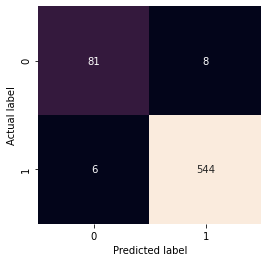

In [ ]:
conf_mat = confusion_matrix(y_actual, y_predicted)
plot_conf_mat(conf_mat)  

So, in case this model says there is tumor we can be pretty sure that he is right.
And these results are making  sense because we trained the model on very big amount of tumor images and relatively small number of images without tumor. <br> 
In addition it is better to declare that there is a Tumor by mistake than giving wrong observation that says that there is no tumor while actually there is one which happens in probability of 0.016 according to this confusion matrix.

## Tumor type detection
After we got very good results on the binary classifier now we are creating the network that will detect the tumor type.

In [ ]:
x_train, y_train = X_train.copy(), Y_train.copy()
x_test, y_test = X_test.copy(), Y_test.copy()

In [ ]:
vflip_train = []
rot_train = []
for img in x_train:
    vertical_flip = cv2.flip(img, 0)
    vflip_train.append(vertical_flip)
    rotate_90 = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    rot_train.append(rotate_90)
x_train = x_train + rot_train + vflip_train
y_train = y_train + y_train + y_train

Smoothing and moving to gray scale.
While using data augmentation the model loses its ability for good generalization so we apply blur on the test set too. 

In [ ]:
for i, img in enumerate(x_train):
    x_train[i] = cv2.GaussianBlur(img,(3,3),0) 

Removing all the images of class no_tumor.

In [ ]:
def remove_class(x, y, class_id):
    no_tumors = np.where(y==class_id)[0]
    print(f"Number of samples before removing the No_Tumor class {len(y)}")
    y = np.delete(y, no_tumors)
    x = np.delete(x, no_tumors, axis=0)
    print(f"Number of samples before removing the No_Tumor class {len(y)}")
    print(f"Totally removed {len(no_tumors)} images\n")
    return x, y

In [ ]:
y_train = np.array(y_train, dtype="int64")
x_train = np.array(x_train)
x_train, y_train = remove_class(x_train, y_train, 0)

Number of samples before removing the No_Tumor class 7668
Number of samples before removing the No_Tumor class 6534
Totally removed 1134 images



In [ ]:
y_test = np.array(y_test, dtype="int64")
x_test = np.array(x_test)
x_test, y_test = remove_class(x_test, y_test, 0)

Number of samples before removing the No_Tumor class 639
Number of samples before removing the No_Tumor class 550
Totally removed 89 images



Now we won't have class 0 so class 1 will become 0, 2 become 1 and 3 will become 2

In [ ]:
y_train=y_train-1
y_test=y_test-1

Adjust to CNN

In [ ]:
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.reshape(x_test.shape + (1,))
y_train = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=3)

In [ ]:
early_stop = EarlyStopping(
    monitor='val_accuracy', 
    patience=8,
    mode='auto',
)
cache = "saved_models/best_conf.ckpt"
checkpoint = ModelCheckpoint(cache,
                             monitor='val_accuracy',
                             verbose=False,
                             save_best_only=True,
                             save_weights_only=True,
                             mode='max')

In [ ]:
tumor_types = Sequential(
        [
            Convolution2D(32, (3,3), activation ='relu', input_shape = (128, 128, 1)),
            MaxPooling2D(pool_size=2),
            
            Convolution2D(filters=64, kernel_size=4, padding='same', activation='relu'),
            MaxPooling2D(pool_size=2),
            
            Convolution2D(filters=128, kernel_size=3, padding='same', activation='relu'),
            MaxPooling2D(pool_size=2),
            
            Convolution2D(filters=128, kernel_size=2, padding='same', activation='relu'),
            BatchNormalization(),
            MaxPooling2D(pool_size=2),
            Dropout(0.25),
            
            Flatten(),
            Dense(units=128,activation = 'relu'),
            Dropout(0.25), 
            Dense(units = 64, activation = 'relu'),
            Dense(units = 32, activation = 'relu'),
            Dense(units = 3, activation = 'softmax')
        ]
    )

In [ ]:
tumor_types.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [ ]:
history = tumor_types.fit(x_train,y_train,
                    epochs=50, 
                    callbacks=[checkpoint, early_stop],
                    validation_data=(x_test,y_test),
                    verbose = False,
                    shuffle=True)

In [ ]:
tumor_types.load_weights("saved_models/best_conf.ckpt")

In [ ]:
y_predicted = tumor_types.predict_classes(x_test)
# Get back from catagorical to lables
y_actual = np.argmax(y_test,axis=1) 

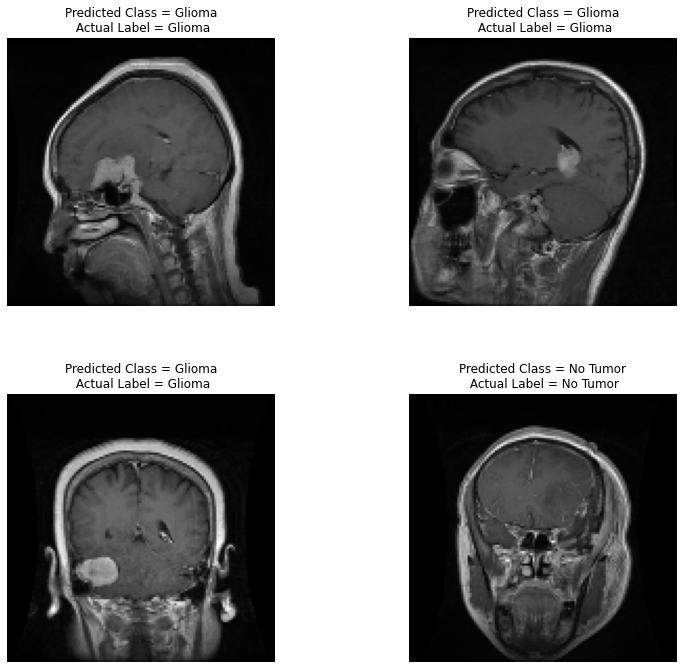

In [ ]:
plot_classified_images(x_test, y_predicted, y_actual)

In [ ]:
print(classification_report(y_actual, y_predicted))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       188
           1       0.93      0.95      0.94       183
           2       0.98      0.98      0.98       179

    accuracy                           0.95       550
   macro avg       0.95      0.95      0.95       550
weighted avg       0.95      0.95      0.95       550



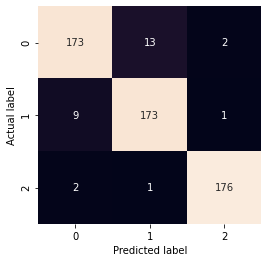

In [ ]:
conf_mat = confusion_matrix(y_actual, y_predicted)
plot_conf_mat(conf_mat)  

So, the results here are pretty much the same as the good general propose CNN model but they were unstable.<br>And the f1-score on the pituitary class is much higher than the Gliomas and Meningiomas so we think it would be good to create two more binary classifiers. 
While assuming we already know that the image contains a tumor. the first will check if its a Pituitary tumor, and if not, we will check if it's Glioma or Meningioma.

## Pituitary detection

Loading again, without shuffling, keeping the previous shuffle.

In [ ]:
x_train, y_train = X_train.copy(), Y_train.copy()
x_test, y_test = X_test.copy(), Y_test.copy()

We assume that the images contain a tumor so we don't need the no_tumor images, we will remove them, and they won't be part of our train and test sets this section. 
But in this change affects the tumors encoding to classes, it will be a little different now.<br>
Class 0 - Glioma or Meningioma<br>
Class 1 - Pituitary<br>
So we are redefining the classes: 1 will be pituitary, 0 will be Glioma and Meningioma

Remove all the images from class no_tumor

In [ ]:
y_train = np.array(y_train, dtype="int64")
x_train = np.array(x_train)
x_train, y_train = remove_class(x_train, y_train, 0)

Number of samples before removing the No_Tumor class 2556
Number of samples before removing the No_Tumor class 2178
Totally removed 378 images



In [ ]:
y_test = np.array(y_test, dtype="int64")
x_test = np.array(x_test)
x_test, y_test = remove_class(x_test, y_test, 0)

Number of samples before removing the No_Tumor class 639
Number of samples before removing the No_Tumor class 550
Totally removed 89 images



In [ ]:
y_train = np.where(y_train==1, 0, y_train)
y_train = np.where(y_train==2, 0, y_train)
y_train = np.where(y_train==3, 1, y_train)

In [ ]:
y_test = np.where(y_test==1, 0, y_test)
y_test = np.where(y_test==2, 0, y_test)
y_test = np.where(y_test==3, 1, y_test)

Smoothing

In [ ]:
for i, img in enumerate(x_train):
    x_train[i] = cv2.GaussianBlur(img,(5,5),0) 

Adjust to CNN

In [ ]:
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.reshape(x_test.shape + (1,))

y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)

In [ ]:
early_stop = EarlyStopping(
    monitor='val_accuracy', 
    patience=8,
    mode='auto',
)
cache = "saved_models/best_conf.ckpt"
checkpoint = ModelCheckpoint(cache,
                             monitor='val_accuracy',
                             verbose=False,
                             save_best_only=True,
                             save_weights_only=True,
                             mode='max')

Although this model got very good performance on its first run (above 98% validation accuracy), it learned so fast and it causes its generalization ability to be very unstable during the learning with very high steps up or down.
So, we decided this time to apply regularization in addition to the dropout.

In [ ]:
pituitary_detection_model = Sequential(
        [
            Convolution2D(32, (3,3), activation ='relu', input_shape = (128, 128, 1)),
            MaxPooling2D(pool_size=2),
            
            Convolution2D(filters=64, kernel_size=4, padding='same', activation='relu'),
            MaxPooling2D(pool_size=2),
            
            Convolution2D(filters=128, kernel_size=3, padding='same', activation='relu'),
            MaxPooling2D(pool_size=2),
            
            Convolution2D(filters=128, kernel_size=2, padding='same', activation='relu'),
            BatchNormalization(),
            MaxPooling2D(pool_size=2),
            Dropout(0.25),
            
            Flatten(),
            Dense(units=128,activation = 'relu'),
            Dropout(0.25), 
            Dense(units = 64, activation = 'relu'),
            Dense(units = 32, activation = 'relu'),
            Dense(units = 2, activation = 'softmax')
        ]
    )

In [ ]:
pituitary_detection_model.compile(optimizer='adam', loss = 'binary_crossentropy',metrics = ['accuracy'])

In [ ]:
pituitary_detection_history = pituitary_detection_model.fit(x_train,y_train,
                    epochs=50, 
                    callbacks=[checkpoint, early_stop],
                    validation_data=(x_test,y_test),
                    verbose = False,
                    shuffle=True)

In [ ]:
pituitary_detection_model.load_weights("saved_models/best_conf.ckpt")

In [ ]:
y_predicted = pituitary_detection_model.predict_classes(x_test)
# Get back from catagorical to lables
y_actual = np.argmax(y_test,axis=1) 

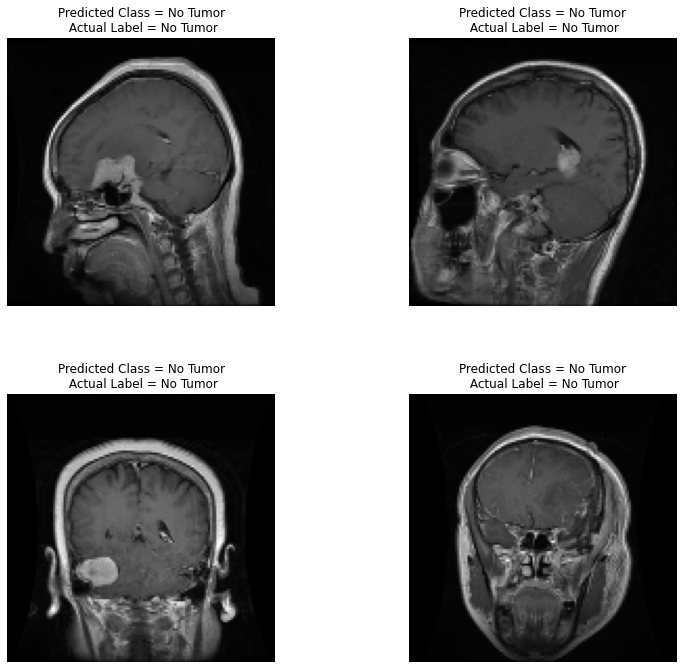

In [ ]:
plot_classified_images(x_test, y_predicted, y_actual)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_actual, y_predicted))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       371
           1       0.98      0.99      0.99       179

    accuracy                           0.99       550
   macro avg       0.99      0.99      0.99       550
weighted avg       0.99      0.99      0.99       550



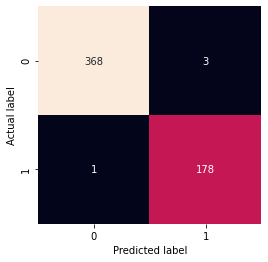

In [ ]:
conf_mat = confusion_matrix(y_actual, y_predicted)
plot_conf_mat(conf_mat)  

As we expected we got very good separation between Gliomas and Meningiomas vs Pituitary tumors. All we have left to do is distinguish between Gliomas and Meningiomas.

## Distinguishing between Gliomas and Meningiomas

As we did with Pituitary, we will remove all the images of classes no tumor and Pituitary from our dataset.<br>

In [ ]:
x_train, y_train = X_train.copy(), Y_train.copy()
x_test, y_test = X_test.copy(), Y_test.copy()

In [ ]:
y_train = np.array(y_train, dtype="int64")
x_train = np.array(x_train)
x_train, y_train = remove_class(x_train, y_train, 0)
x_train, y_train = remove_class(x_train, y_train, 3)

Number of samples before removing the No_Tumor class 2556
Number of samples before removing the No_Tumor class 2178
Totally removed 378 images

Number of samples before removing the No_Tumor class 2178
Number of samples before removing the No_Tumor class 1460
Totally removed 718 images



In [ ]:
y_test = np.array(y_test, dtype="int64")
x_test = np.array(x_test)
x_test, y_test = remove_class(x_test, y_test, 0)
x_test, y_test = remove_class(x_test, y_test, 3)

Number of samples before removing the No_Tumor class 639
Number of samples before removing the No_Tumor class 550
Totally removed 89 images

Number of samples before removing the No_Tumor class 550
Number of samples before removing the No_Tumor class 371
Totally removed 179 images



In [ ]:
y_train = np.where(y_train==1, 0, y_train)
y_train = np.where(y_train==2, 1, y_train)

In [ ]:
y_test = np.where(y_test==1, 0, y_test)
y_test = np.where(y_test==2, 1, y_test)

Smoothing

In [ ]:
for i, img in enumerate(x_train):
    x_train[i] = cv2.GaussianBlur(img,(3,3),0)

We didn't got the results we expected to so we decided to augment the data here too to increase the generalization ability of the model. This time, we will duplicate the dataset just once by applying vertical flip and then 90 degrees rotation on every image.

In [ ]:
vp_and_rotate = []
for img in x_train:
    vertical_flip = cv2.flip(img, 0)
    vp_rotated = cv2.rotate(vertical_flip, cv2.ROTATE_90_CLOCKWISE)
    vp_and_rotate.append(vp_rotated)
x_train = np.concatenate((x_train, vp_and_rotate))
y_train = np.concatenate((y_train, y_train))

Adjust to CNN

In [ ]:
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.reshape(x_test.shape + (1,))

y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)

In [ ]:
early_stop = EarlyStopping(
    monitor='val_accuracy', 
    patience=8,
    mode='auto',
)
cache = "saved_models/best_conf.ckpt"
checkpoint = ModelCheckpoint(cache,
                             monitor='val_accuracy',
                             verbose=False,
                             save_best_only=True,
                             save_weights_only=True,
                             mode='max')

In [ ]:
glioma_vs_meningioma_model = Sequential(
        [
            Convolution2D(filters=32, kernel_size=3, activation ='relu', input_shape = (128, 128, 1)),
            MaxPooling2D(pool_size=2),
            
            Convolution2D(filters=64, kernel_size=4, padding='same', activation='relu'),
            MaxPooling2D(pool_size=2),
            
            Convolution2D(filters=128, kernel_size=3, padding='same', activation='relu'),
            MaxPooling2D(pool_size=2),
            
            Convolution2D(filters=128, kernel_size=2, padding='same', activation='relu'),
            BatchNormalization(),
            MaxPooling2D(pool_size=2),
            Dropout(0.25),
            
            Flatten(),
            Dense(units=128,activation = 'relu'),
            Dropout(0.25), 
            Dense(units = 64, activation = 'relu'),
            Dense(units = 32, activation = 'relu'),
            Dense(units = 2, activation = 'softmax')
        ]
    )

In [ ]:
glioma_vs_meningioma_model.compile(optimizer='adam', loss = 'binary_crossentropy',metrics = ['accuracy'])

In [ ]:
history = glioma_vs_meningioma_model.fit(x_train,y_train,
                    epochs=50, 
                    callbacks=[checkpoint, early_stop],
                    validation_data=(x_test,y_test),
                    verbose = False,
                    shuffle=True)

In [ ]:
glioma_vs_meningioma_model.load_weights("saved_models/best_conf.ckpt")

In [ ]:
y_predicted = glioma_vs_meningioma_model.predict_classes(x_test)
# Get back from catagorical to lables
y_actual = np.argmax(y_test, axis=1) 

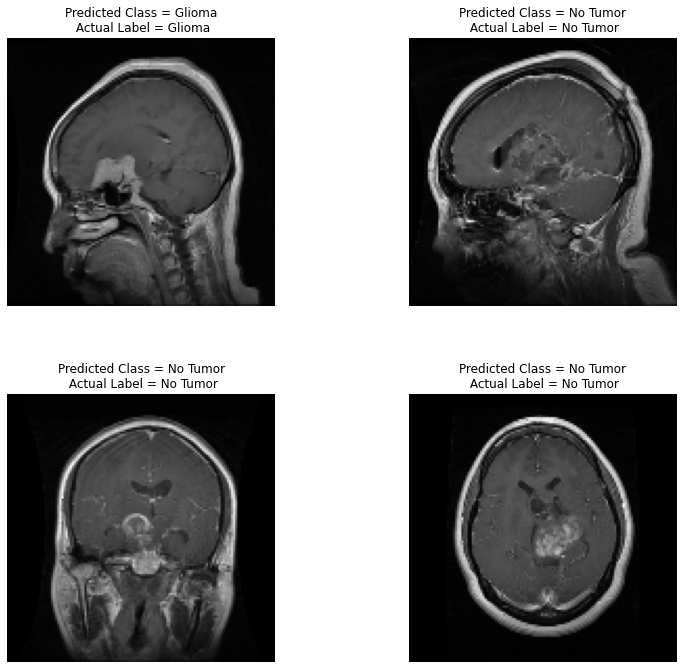

In [ ]:
plot_classified_images(x_test, y_predicted, y_actual)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_actual, y_predicted))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       188
           1       0.94      0.94      0.94       183

    accuracy                           0.94       371
   macro avg       0.94      0.94      0.94       371
weighted avg       0.94      0.94      0.94       371



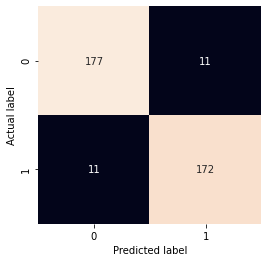

In [ ]:
conf_mat = confusion_matrix(y_actual, y_predicted)
plot_conf_mat(conf_mat)  

The data augmenting indeed helped us the achieve much better results here, but we still wish for the 95% and more accuracy so we are examining the power of Random Forest which was some of the best classifiers in our previuos classifications.

## Distinguish between Gliomas and Meningiomas using Random Forest

We wanted to try the Random Forest Glioma separator that will classify only Gliomas and Meningiomas. because the CNN got 94% accuracy on this task and maybe we will see something better here.

              precision    recall  f1-score   support

           1       0.99      0.88      0.93       188
           2       0.89      0.99      0.94       183

    accuracy                           0.94       371
   macro avg       0.94      0.94      0.94       371
weighted avg       0.94      0.94      0.94       371

Random Forest classification result is: 


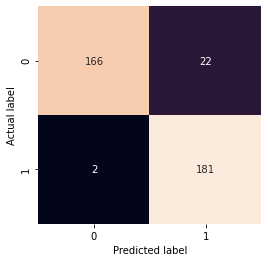

In [ ]:
def glioma_vs_meningioma(name, x_train, y_train, x_test, y_test):

    model = RandomForestClassifier(n_estimators=600, min_samples_split=2, min_samples_leaf=2,
                                   max_features='auto', max_depth=60, bootstrap=False)

    train_samples = [(x, y) for (x, y) in zip(x_train, y_train) if y in [1, 2]]
    test_samples = [(x, y) for (x, y) in zip(x_test, y_test) if y in [1, 2]]

    new_x_train = [item[0] for item in train_samples]
    new_y_train = [item[1] for item in train_samples]
    new_x_test = [item[0] for item in test_samples]
    new_y_test = [item[1] for item in test_samples]

    model.fit(new_x_train, new_y_train)
    predict = model.predict(new_x_test)

    print(classification_report(new_y_test, predict))
    print(f'{name} classification result is: ')

    con_mat = confusion_matrix(new_y_test, predict)
    plot_conf_mat(con_mat)


x_train, y_train = X_train.copy(), Y_train.copy()
x_test, y_test = X_test.copy(), Y_test.copy()
x_train, x_test, y_train, y_test = adjust_dataset_to_sklearn(x_train, x_test, y_train, y_test)
glioma_vs_meningioma("Random Forest", x_train, y_train, x_test, y_test)

The resulting model turn out to be good but not great, and it's CNN equivalent is more balanced so we decided to move forward with it.<br>
As improvement suggestion, we think it will be good to add this Random Forest to the hierarchy and in case he indicate that an image is a Glioma we will believe him and in case it indicates that an image is Meningioma we will give it to second opinion to CNN and classify as the CNN told. 

## CNN Hierarchical classification:

In [ ]:
x_train, y_train = X_train.copy(), Y_train.copy()
x_test, y_test = X_test.copy(), Y_test.copy()

hierarchical classification with CNN classification result is: 
              precision    recall  f1-score   support

           0       0.93      0.91      0.92        89
           1       0.93      0.93      0.93       188
           2       0.93      0.92      0.93       183
           3       0.98      0.99      0.99       179

    accuracy                           0.94       639
   macro avg       0.94      0.94      0.94       639
weighted avg       0.94      0.94      0.94       639



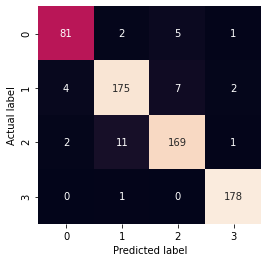

In [ ]:
def hierarchy_with_cnn(models, trusted_tag_array, predict_shifts, x_test, y_test):
    new_y_test, new_predict = [], []
    chained_x_test, chained_y_test = x_test, y_test

    for index, model in enumerate(models):
        chained_y_test = np.array(chained_y_test, dtype="int64")
        # chained_y_test = tf.keras.utils.to_categorical(chained_y_test, num_classes=4)
        chained_x_test = np.array(chained_x_test)
        if index == 0:
            chained_x_test = chained_x_test.reshape(chained_x_test.shape + (1,))

        predict = model.predict_classes(chained_x_test)
        combined = zip(chained_x_test, chained_y_test, predict)
        chained_x_test, chained_y_test = [], []

        for x, y_actual, pred in combined:
            if index == len(models) - 1 or pred == trusted_tag_array[index]:
                new_y_test += [y_actual]
                new_predict += [pred + predict_shifts[index]]
            else:
                chained_x_test += [x]
                chained_y_test += [y_actual]

    print(f'hierarchical classification with CNN classification result is: ')
    print(classification_report(new_y_test, new_predict))

    conf_mat = confusion_matrix(new_y_test, new_predict)
    plot_conf_mat(conf_mat)

models = [tumor_detection_model,
          pituitary_detection_model,
          glioma_vs_meningioma_model]

trusted_tag_array = [0, 1]
predict_shifts = [0, 2, 1]

hierarchy_with_cnn(models, trusted_tag_array, predict_shifts, x_test, y_test)

# Cross validation

The last thing we will present is called cross validation. <br>
This technique uses to evaluate the accuracy of the model regardless on what was the images that used for testing / training. <br>
The dataset will split randomly into five equal parts, the model will use 4 of them for training and the last for testing.<br>
The new part here is that we will train and evaluate the model 5 times, when every time other part will be used as test set.<br>
And we will calculate the average accuracy yielded from this process and it will be good independent chart for the generalization ability of the model.<br>
For this task we will use StratifiedKFold.<br>
It shuffles the data and splits the data into n_splits parts. Now, it will use each part as a test set.<br>
As said, we defined n_splits which will cause the data to split to 5 folds, each of which consists of 20% of the whole dataset thus we will have 80% for training and 20% for testing.

Recalling that we don't have equal number of images in each class, StratifiedKFold will help us handle it. <br>
StratifiedKFold splits the dataset with respect to the number of images in each class. <br>
The ratio between all the classes will be saved in each fold.

In [ ]:
x_train, y_train = X_train.copy(), Y_train.copy()
x_test, y_test = X_test.copy(), Y_test.copy()
x_train, x_test, y_train, y_test = shuffle_data(x_train, x_test, y_train, y_test)


In [ ]:
base_model = Sequential(
        [
            Convolution2D(32, (3,3), activation ='relu', input_shape = (128, 128, 1)),
            MaxPooling2D(pool_size=2),
            
            Convolution2D(filters=64, kernel_size=4, padding='same', activation='relu'),
            MaxPooling2D(pool_size=2),
            
            Convolution2D(filters=128, kernel_size=3, padding='same', activation='relu'),
            BatchNormalization(),
            MaxPooling2D(pool_size=2),
            
            Convolution2D(filters=128, kernel_size=2, padding='same', activation='relu'),
            MaxPooling2D(pool_size=2),
            Dropout(0.25), 
            
            Flatten(),
            
            Dense(units=128,activation = 'relu'),
            BatchNormalization(),
            Dropout(0.25),
            
            Dense(units = 64, activation = 'relu'),
            Dense(units = 32, activation = 'relu'),
            Dense(units = 4, activation = 'softmax')
        ]
    )

In [ ]:
base_model.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])
base_model_initial_weights = base_model.get_weights()

In [ ]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cvscores = []
X = np.concatenate((X_train, X_test))
Y = np.concatenate((Y_train, Y_test))

for train, test in kfold.split(X, Y):
    x_train, x_test, y_train, y_test = adjust_dataset_to_CNN(X[train], X[test], Y[train], Y[test])
    model = base_model
    model.set_weights(base_model_initial_weights)
    model.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])
    early_stop = EarlyStopping(
        monitor='val_accuracy', 
        patience=8,
        mode='auto',
    )
    cache = "saved_models/best_conf.ckpt"
    checkpoint = ModelCheckpoint(
        cache,
        monitor='val_accuracy',
        verbose=False,
        save_best_only=True,
        save_weights_only=True,
        mode='max')
    history = model.fit(x_train,y_train,
                    epochs=50, 
                    callbacks=[early_stop, checkpoint],
                    validation_data=(x_test, y_test),
                    verbose = False)
    model.load_weights("saved_models/best_conf.ckpt")
    scores = model.evaluate(x_test, y_test, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

accuracy: 92.33%
accuracy: 93.11%
accuracy: 92.80%
accuracy: 93.43%
accuracy: 93.43%


In [ ]:
print("Final accuracy of this model is: %.2f%%" % (np.mean(cvscores)))
print("Taking in count the standard deviation we getting the result: %.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

Final accuracy of this model is: 93.02%
Taking in count the standard deviation we getting the result: 93.02% (+/- 0.42%)


We must mention here that in some runns of the cross validation, the accuracy jumps to 94.5% - 95% accuracy on a specific fold, and we suspect it might explain the high results in the previous sections instead of the data augmentation itself.

# Summary

In this project we've used different approaches to solve an image recognition problem, from simple sklearn methods to CNN, and also using OpenCV in order to process the data for better model performances. <br>
Then we tried a classification method called Hierarchical Classification with models from sklearn library. <br>
After that, we tried to improve and get height accuracy with our CNN model. <br>
Later, we tried to split the task of tumor type classification to three binary classification problems and solve them hierarchically. <br>
Our final result was reduction of the multiclass classification problem to distinguishing between Glioma and Meningioma tumors which had the worst performances in our hierarchical CNN structure.

# Results

Deterministic data augmentation -  gave us 95% accuracy and it was the highest score we have got. <br>
Hierarchical classification using CNN - We got a total score of 94% accuracy but distinguishing between Glioma and Meningioma tumors was its main weak point and improvement there and in the precision of the no tumor class in the first classifier in the hierarchy may give us results of above 98% accuracy. <br>
Hierarchical classification - 87% accuracy with Meningioma class as main weak point. <br>

# Self review

First of all, we must mention that we had a long way with our learning process.<br>
This was the first time we got to read an academic article and get our hands dirty in this type of code. It was a very nice and interesting experience. <br>
Looking back we could have implemented the cross-validation and data shuffling as the first thing after getting significant results with CNN. <br>
We suspect that the accuracy variation between performance with different folds as test set might explain the improvement we saw from smoothing and data augmentation. We could have saved a lot of time and effort in that way.<br>
In addition, we should have first viewed the relevant literature on this topic instead of leaning on algorithms that we knew beforehand and weren't fit to our dataset.<br>
Looking back, increasing the amount of data for the train and test would produce better results especially for the CNN because Neural Networks performs much better with great amount of data. <br>
We probably shouldn't pay so much attention to sklearn ML models, because most of them were not promising, and the only exception with Random Forest which showed great results on it's own, and SVM which produced nice separations. <br>
Decision trees and Naïve Bayes should have been disregarded because they are simply not suitable enough for this type of classification. <br>
Knowing in advance the basics of OpenCV would save as much coding time, running time and some troubles.

## Improvement suggestions

<h3>If we had more time, these are the improvement suggestions we would have done</h3>
<ol>
    <li>Try to find more images to add to our dataset in order to increase the amount oof images that our models will train on.</li>
    <li>Split the data with balance between test and train in respect of number of images in each category.</li>
    <li>Investigate the CNN layers to understand if and where l1/l2 regularization is needed.</li>
    <li>Apply segmentation with k-mean to help the models reveal the tumor area.</li>
    <li>Use Capsule Neural Network for classification which is a Novel Neural Network that could perform well even with low amount of data like in our case.</li>
    <li>Use stochastic data augmentation in running time instead of deterministic pre-learning.</li>
    <li>Improve the glioma_vs_meningioma model.</li>
</ol>